<a href="https://colab.research.google.com/github/Julian981012/Proyecto-3--P2/blob/main/Practica_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="udeA logo" height="150px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true" align="left" hspace="50px" vspace="0px" style="width:107px;height:152px;"></p>
<h1><font color='0B5345'> <center>
Bioseñales y Sistemas </center></font></h1>
<h2><font color='0B5345'> <center>
Práctica 4  </center></font></h2>
<h4><font color='0B5345'>
<center></center>
<center>Julian Olaya</center>
</font></h4>

<font  face="Courier New" size="3">
<p1><center> </center></p1>



<p3><center><b><font color='0B5345' face="Lucida Calligraphy,Comic Sans MS,Lucida Console" size="5">Universidad de Antioquia</font></b> </center></p3>
</font>

**Introducción:**
En este trabajo, se utilizaron parámetros estadísticos extraídos de señales de EMG para entrenar modelos de redes neuronales. Estos parámetros, como la RMS  del EMG (IEMG), el valor medio absoluto (MAV) y la varianza del EMG (VAR), permiten obtener información relevante sobre las características temporales y espectrales de las señales de EMG

**Corrección proyecto 1:**

---



In [288]:
import os
import google.colab as drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from csv import reader as reader_csv
import scipy.signal as signal
import scipy.io as sio
import numpy as np
import glob
import pandas as pd
import math
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import shapiro , levene, kruskal
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix
from itertools import product
from sklearn import svm
from sklearn.metrics import classification_report


In [42]:
# Montar Google Drive
drive.mount('/content/drive')

# Ruta de la carpeta principal
ruta_datos = '/content/drive/My Drive/EMG_data_for_gestures-master'

todos_los_datos = []  # Lista para almacenar los datos de todos los sujetos

# Iterar sobre cada carpeta numerada
for carpeta_sujeto in sorted(os.listdir(ruta_datos), key=int):  # Asegurar orden numérico
    ruta_sujeto = os.path.join(ruta_datos, carpeta_sujeto)
    if os.path.isdir(ruta_sujeto):
        # Iterar sobre los archivos de datos en cada carpeta de sujeto
        for archivo_datos in os.listdir(ruta_sujeto):
            if archivo_datos.endswith('.txt') and archivo_datos.startswith('1_raw'):
                ruta_archivo = os.path.join(ruta_sujeto, archivo_datos)
                # Leer el archivo de datos y convertirlo en un DataFrame de Pandas
                datos = pd.read_csv(ruta_archivo, delim_whitespace=True, header=None, skiprows=1)
                datos.columns = ['tiempo'] + [f'canal_{i}' for i in range(1, 9)] + ['clase']
                datos['sujeto'] = int(carpeta_sujeto)
                todos_los_datos.append(datos)

# Concatenar todos los DataFrames en uno solo
todos_los_datos = pd.concat(todos_los_datos, ignore_index=True)

# Ordenar por sujeto para asegurar que los datos estén organizados correctamente
todos_los_datos = todos_los_datos.sort_values(by=['sujeto', 'tiempo']).reset_index(drop=True)

# Imprimir el DataFrame combinado
display(todos_los_datos)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,tiempo,canal_1,canal_2,canal_3,canal_4,canal_5,canal_6,canal_7,canal_8,clase,sujeto
0,1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0.0,1
1,5,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0.0,1
2,6,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1
3,7,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1
4,8,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
2195966,54832,-0.00004,-0.00006,-0.00008,-0.00014,-0.00002,0.00000,-0.00002,-0.00001,0.0,36
2195967,54833,-0.00004,-0.00006,-0.00008,-0.00014,-0.00002,0.00000,-0.00002,-0.00001,0.0,36
2195968,54834,-0.00004,-0.00006,-0.00008,-0.00014,-0.00002,0.00000,-0.00002,-0.00001,0.0,36
2195969,54835,-0.00004,-0.00006,-0.00008,-0.00014,-0.00002,0.00000,-0.00002,-0.00001,0.0,36


In [45]:
# Función para aplicar el operador Teager-Kaiser Energy Operator (TKEO) a una señal
def tkeo(signal):
    tkeo_signal = signal**2 - np.roll(signal, 1) * np.roll(signal, -1)
    return tkeo_signal

# Función para aplicar el TKEO a todas las columnas de señales en un DataFrame
def aplicar_tkeo(data):
    tkeo_data = data.copy()
    for col in tkeo_data.columns[1:-2]:  # Excluir las columnas 'tiempo','clase' y 'sujeto'
        tkeo_data[col] = tkeo(tkeo_data[col])
    return tkeo_data

# Aplicar el TKEO al DataFrame df_tkeo
df_tkeo = aplicar_tkeo(todos_los_datos)

display(df_tkeo)

,tiempo,canal_1,canal_2,canal_3,canal_4,canal_5,canal_6,canal_7,canal_8,clase,sujeto
0,1,5.000000e-10,-6.000000e-10,-7.000000e-10,-9.000000e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1
1,5,2.000000e-10,6.000000e-10,3.000000e-10,9.000000e-10,0.000000e+00,-1.000000e-10,0.000000e+00,2.000000e-10,0.0,1
2,6,2.000000e-10,3.000000e-10,6.000000e-10,0.000000e+00,1.000000e-10,2.000000e-10,1.000000e-10,2.000000e-10,0.0,1
3,7,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1
4,8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
2195966,54832,0.000000e+00,4.135903e-25,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,36
2195967,54833,0.000000e+00,4.135903e-25,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,36
2195968,54834,0.000000e+00,4.135903e-25,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,36
2195969,54835,0.000000e+00,6.000000e-10,0.000000e+00,1.120000e-08,-2.000000e-10,0.000000e+00,2.000000e-10,0.000000e+00,0.0,36


In [47]:
def calcular_rms(signal):
    return np.sqrt(np.mean(signal**2))

def calcular_varianza(signal):
    return np.var(signal)

def calcular_valor_absoluto_medio(signal):
    return np.mean(np.abs(signal))

def calcular_pendiente_valor_absoluto_medio(signal):
    return np.mean(np.diff(np.abs(signal)))

def calcular_cambios_signo_pendiente(signal):
    return np.sum(np.diff(np.sign(np.diff(signal))) != 0)

def calcular_longitud_forma_de_onda(signal):
    return np.sum(np.abs(np.diff(signal)))

def calcular_cruces_por_cero(signal):
    return np.sum(np.diff(np.sign(signal)) != 0)

def extraer_caracteristicas(data):
    num_canales = data.shape[1]
    features = []
    for canal in range(num_canales):
        rms = calcular_rms(data[:, canal])
        var = calcular_varianza(data[:, canal])
        mav = calcular_valor_absoluto_medio(data[:, canal])
        mav_slope = calcular_pendiente_valor_absoluto_medio(data[:, canal])
        ssc = calcular_cambios_signo_pendiente(data[:, canal])
        wfl = calcular_longitud_forma_de_onda(data[:, canal])
        zc = calcular_cruces_por_cero(data[:, canal])
        features.extend([rms, var, mav, mav_slope, ssc, wfl, zc])
    return np.array(features)

In [48]:
# Ordenar el DataFrame original por la columna 'clase'
df_ordenado = df_tkeo.sort_values(by='clase')

# Diccionario para almacenar los resultados
resultados = []

# Iterar sobre los grupos definidos por los valores de la columna 'clase'
for clase, grupo in df_ordenado.groupby('clase'):
    # Iterar sobre las columnas de interés (de la 2 a la 9)
    for columna in df_tkeo.columns[1:9]:
        canal = grupo[columna]

        # Aplicar las características a cada canal
        caracteristicas = {
            'clase': clase,
            'canal': columna,
            'rms': calcular_rms(canal),
            'variance': calcular_varianza(canal),
            'mean_absolute_value': calcular_valor_absoluto_medio(canal),
            'mean_absolute_value_slope': calcular_pendiente_valor_absoluto_medio(canal),
            'slope_sign_changes': calcular_cambios_signo_pendiente(canal),
            'wave_form_length': calcular_longitud_forma_de_onda(canal),
            'zero_crossings': calcular_cruces_por_cero(canal)
        }

        # Añadir los resultados a la lista
        resultados.append(caracteristicas)

# Convertir la lista de diccionarios en un DataFrame
df_resultados = pd.DataFrame(resultados)

# El DataFrame df_resultados ahora contiene los resultados de las características para cada grupo de la columna 'clase', cada canal y sujeto.
display(df_resultados)  # Muestra las primeras filas del DataFrame de resultados

,clase,canal,rms,variance,mean_absolute_value,mean_absolute_value_slope,slope_sign_changes,wave_form_length,zero_crossings
0,0.0,canal_1,5.710464e-08,3.242738e-15,4.859281e-09,-3.477272e-16,384778,0.010781,265477
1,0.0,canal_2,4.094726e-08,1.670220e-15,2.890346e-09,-4.172726e-16,396186,0.006367,272288
2,0.0,canal_3,3.971319e-08,1.568380e-15,3.345339e-09,-4.868180e-16,409128,0.007397,278490
3,0.0,canal_4,8.003825e-08,6.341809e-15,9.169875e-09,-6.259089e-16,408170,0.020164,280523
4,0.0,canal_5,9.697832e-08,9.276585e-15,1.303510e-08,-1.164555e-28,407807,0.028619,282576
...,...,...,...,...,...,...,...,...,...
59,7.0,canal_4,2.151547e-08,4.480675e-16,4.325808e-09,4.272482e-26,2423,0.000046,1641
60,7.0,canal_5,1.167581e-07,1.303634e-14,2.784305e-08,1.270071e-25,2333,0.000319,1661
61,7.0,canal_6,1.080506e-07,1.127701e-14,2.284388e-08,-5.603256e-26,2406,0.000272,1688
62,7.0,canal_7,7.108336e-09,4.878080e-17,1.519247e-09,6.828968e-27,2337,0.000018,1608


In [49]:
resultados_1= pd.DataFrame(resultados)

resultados_1.to_csv('output.csv', index=False)

In [54]:
# Ordenar DataFrame Tkeo
df_ordenado_tkeo = df_tkeo.sort_values(by='clase')

# Diccionario para almacenar los resultados
resultados_tkeo = []

# Iterar sobre los grupos definidos por los valores de la columna 'clase'
for clase, grupo in df_ordenado_tkeo.groupby('clase'):
    # Iterar sobre las columnas de interés (de la 2 a la 9)
    for columna in df_tkeo.columns[1:9]:
        canal = grupo[columna]

        # Aplicar las características a cada canal
        caracteristicas = {
            'sujeto': grupo['sujeto'].iloc[0],  # Tomamos el valor del sujeto del primer elemento del grupo
            'clase': clase,
            'canal': columna,
            'rms': calcular_rms(canal),
            'variance': calcular_varianza(canal),
            'mean_absolute_value': calcular_valor_absoluto_medio(canal),
            'mean_absolute_value_slope': calcular_pendiente_valor_absoluto_medio(canal),
            'slope_sign_changes': calcular_cambios_signo_pendiente(canal),
            'wave_form_length': calcular_longitud_forma_de_onda(canal),
            'zero_crossings': calcular_cruces_por_cero(canal)
        }

        # Añadir los resultados a la lista
        resultados_tkeo.append(caracteristicas)

# Convertir la lista de diccionarios en un DataFrame
df_resultados_tkeo = pd.DataFrame(resultados_tkeo)

# El DataFrame df_resultados_tkeo ahora contiene los resultados de las características para cada grupo de la columna 'clase', cada canal y sujeto.
display(df_resultados_tkeo)  # Muestra las primeras filas del DataFrame de resultados

,sujeto,clase,canal,rms,variance,mean_absolute_value,mean_absolute_value_slope,slope_sign_changes,wave_form_length,zero_crossings
0,1,0.0,canal_1,5.710464e-08,3.242738e-15,4.859281e-09,-3.477272e-16,384778,0.010781,265477
1,1,0.0,canal_2,4.094726e-08,1.670220e-15,2.890346e-09,-4.172726e-16,396186,0.006367,272288
2,1,0.0,canal_3,3.971319e-08,1.568380e-15,3.345339e-09,-4.868180e-16,409128,0.007397,278490
3,1,0.0,canal_4,8.003825e-08,6.341809e-15,9.169875e-09,-6.259089e-16,408170,0.020164,280523
4,1,0.0,canal_5,9.697832e-08,9.276585e-15,1.303510e-08,-1.164555e-28,407807,0.028619,282576
...,...,...,...,...,...,...,...,...,...,...
59,30,7.0,canal_4,2.151547e-08,4.480675e-16,4.325808e-09,4.272482e-26,2423,0.000046,1641
60,30,7.0,canal_5,1.167581e-07,1.303634e-14,2.784305e-08,1.270071e-25,2333,0.000319,1661
61,30,7.0,canal_6,1.080506e-07,1.127701e-14,2.284388e-08,-5.603256e-26,2406,0.000272,1688
62,30,7.0,canal_7,7.108336e-09,4.878080e-17,1.519247e-09,6.828968e-27,2337,0.000018,1608


In [55]:
# Concatenar los dos DataFrames
df_final = pd.concat([df_resultados, df_resultados_tkeo], ignore_index=True)

df_resultados['TKEO'] = 0

df_resultados_tkeo['TKEO'] = 1

# Mostrar las primeras filas del DataFrame resultante
display(df_final)

,clase,canal,rms,variance,mean_absolute_value,mean_absolute_value_slope,slope_sign_changes,wave_form_length,zero_crossings,sujeto
0,0.0,canal_1,5.710464e-08,3.242738e-15,4.859281e-09,-3.477272e-16,384778,0.010781,265477,NaN
1,0.0,canal_2,4.094726e-08,1.670220e-15,2.890346e-09,-4.172726e-16,396186,0.006367,272288,NaN
2,0.0,canal_3,3.971319e-08,1.568380e-15,3.345339e-09,-4.868180e-16,409128,0.007397,278490,NaN
3,0.0,canal_4,8.003825e-08,6.341809e-15,9.169875e-09,-6.259089e-16,408170,0.020164,280523,NaN
4,0.0,canal_5,9.697832e-08,9.276585e-15,1.303510e-08,-1.164555e-28,407807,0.028619,282576,NaN
...,...,...,...,...,...,...,...,...,...,...
123,7.0,canal_4,2.151547e-08,4.480675e-16,4.325808e-09,4.272482e-26,2423,0.000046,1641,30.0
124,7.0,canal_5,1.167581e-07,1.303634e-14,2.784305e-08,1.270071e-25,2333,0.000319,1661,30.0
125,7.0,canal_6,1.080506e-07,1.127701e-14,2.284388e-08,-5.603256e-26,2406,0.000272,1688,30.0
126,7.0,canal_7,7.108336e-09,4.878080e-17,1.519247e-09,6.828968e-27,2337,0.000018,1608,30.0


**Filtrado:**

-----
A la hora de realizar un filtro, es importante tener en cuenta 3 cosas: Frecuencia de muestreo, tipo de filtro y orden de filtro, es por eso que en este trabajo, se trabajó con 2 tipos de filtro FIR(ideales para preservar la forma de onda original de la señal) y filtro IIR (adecuados para atenuar componentes de baja frecuencia en señales EMG), en mi caso se realizaron ambos filtros para ver como se comportaban, además, se le encontró el mínimo error cuadrático y ya con esta información poder hacer una elección más consciente y aterrizada a las necesidades del proyecto

In [89]:
def calculate_filter_kernel(m, f, w):
    m = np.arange(-m/2, (m/2)+1)
    kernel = np.zeros((m.shape[0]))
    kernel[m==0] = 2 * np.pi * f  # No division by zero
    kernel[m!=0] = np.sin(2 * np.pi * f * m[m!=0]) / m[m!=0]  # Sinc
    kernel = kernel * w  # Windowing
    kernel = kernel / np.sum(kernel)  # Normalization to unity gain at DC
    return kernel

In [90]:
def invert_filter_spectrum(b):
    inverted_b = -b
    inverted_b[int((inverted_b.shape[0]-1)/2)] = inverted_b[int((inverted_b.shape[0]-1)/2)] + 1
    return inverted_b

In [91]:
def design_fir_filter(m, f, w, t=None):
    f = np.squeeze(f)
    f = f / 2
    w = np.squeeze(w)
    if f.ndim == 0:  # low pass
        coefficients = calculate_filter_kernel(m, f, w)
    else:
        coefficients = calculate_filter_kernel(m, f[0], w)  # band

    if f.ndim == 0 and t == 'high':
        coefficients = invert_filter_spectrum(coefficients)
    elif f.size == 2:
        coefficients = coefficients + invert_filter_spectrum(calculate_filter_kernel(m, f[1], w))  # reject
        if t is None or (t != 'stop'):
            coefficients = invert_filter_spectrum(coefficients)  # bandpass
    return coefficients


In [159]:
def filter_design(sampling_rate, low_cutoff=0, high_cutoff=0, reverse_filter=0):
    # Constants
    TRANS_WIDTH_RATIO = 0.5
    nyquist_frequency = sampling_rate / 2

    # Convert highpass to inverted lowpass
    if high_cutoff == 0:
        high_cutoff = low_cutoff
        low_cutoff = 0
        reverse_filter = 1

    if low_cutoff > 0 and high_cutoff > 0:
        edge_array = np.array([low_cutoff, high_cutoff])
    else:
        edge_array = np.array([high_cutoff])

    # Check cutoff frequencies
    if np.any(edge_array < 0) or np.any(edge_array >= nyquist_frequency):
        print('Cutoff frequency out of range')
        return False

    # Max stop-band width
    max_bandwidth_array = edge_array.copy()
    if reverse_filter == 0:
        max_bandwidth_array[-1] = nyquist_frequency - edge_array[-1]
    elif len(edge_array) == 2:
        max_bandwidth_array = np.diff(edge_array) / 2
    max_transition_width = np.min(max_bandwidth_array)

    # Default filter order heuristic
    if reverse_filter == 1:
        transition_width = np.min([np.max([max_transition_width * TRANS_WIDTH_RATIO, 2]), max_transition_width])
    else:
        transition_width = np.min([np.max([edge_array[0] * TRANS_WIDTH_RATIO, 2]), max_transition_width])

    print(transition_width)

    filter_order = 2 / (transition_width / sampling_rate)
    filter_order = np.ceil(filter_order / 2) * 2

    # Passband edge to cutoff (transition band center; -6 dB)
    transition_band_array = [[transition_width, [-transition_width, transition_width]],
                             [-transition_width, [transition_width, -transition_width]]]
    cutoff_array = edge_array + np.array(transition_band_array[reverse_filter][len(edge_array) - 1]) / 2
    print('pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): ' + str(cutoff_array) + ' Hz\n')

    # Window
    window_array = signal.hamming(int(filter_order) + 1)

    # Filter coefficients
    if reverse_filter == 1:
        filter_type_array = ['high', 'stop']
        b = design_fir_filter(filter_order, cutoff_array / nyquist_frequency, window_array,
                              filter_type_array[len(edge_array) - 1])
    else:
        b = design_fir_filter(filter_order, cutoff_array / nyquist_frequency, window_array)

    return filter_order, b

In [157]:
def plot_frequency_response(b, a, order, nyquist_rate=1):

    w, h = signal.freqz(b, a)
    h_db = 20 * np.log10(abs(h))

    plt.figure()
    plt.subplot(311)
    plt.plot((w / max(w)) * nyquist_rate, abs(h))
    plt.ylabel('Magnitude')
    plt.title('Frequency response. Orden: ' + str(order))
    [xmin, xmax, ymin, ymax] = plt.axis()

    plt.grid(True)

    plt.subplot(312)
    plt.plot((w / max(w)) * nyquist_rate, h_db)
    plt.ylabel('Magnitude (db)')
    plt.title('Frequency response. Orden: ' + str(order))
    plt.grid(True)

    plt.subplot(313)
    h_phase = np.unwrap(np.arctan2(np.imag(h), np.real(h)))
    plt.plot((w / max(w)) * nyquist_rate, h_phase)
    plt.ylabel('Phase (radians)')
    plt.title('Phase response. Orden: ' + str(order))
    plt.subplots_adjust(hspace=0.5)
    plt.grid(True)
    plt.show()

5.0
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [12.5] Hz



<ipython-input-159-3de9e422f209>:48: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  window_array = signal.hamming(int(filter_order) + 1)


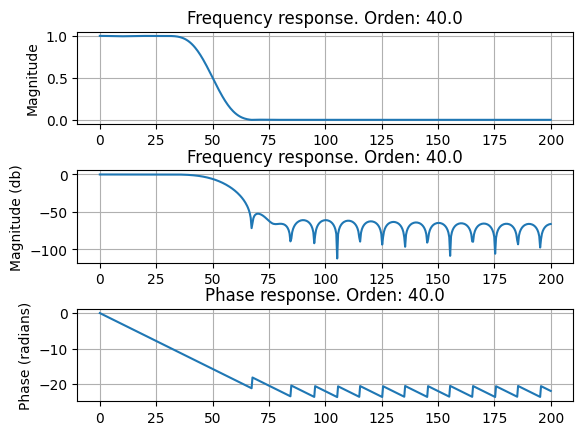

In [160]:
fs = 100
orden, bandpass = filter_design(fs, low_cutoff=0, high_cutoff=10, reverse_filter=0)
#plot
plot_frequency_response(bandpass,1,orden, 200);


**Para la función filter_design:**

*   Frecuencia de muestreo (fs) = 100 Hz
*   Frecuencia normalizada para bajas (wna) = 10 / (fs/2) = 0.2
*   Se obtuvo un orden de 40 - Un orden de 40 para el filtro FIR puede considerarse relativamente alto, lo que puede resultar en una mayor atenuación de las frecuencias no deseadas pero también en una mayor distorsión de la forma de onda de la señal.


---


 Este tipo de filtro es comúnmente utilizado para procesar señales digitales, la función permite especificar la frecuencia de muestreo y las frecuencias de corte para diseñar el filtro. Dependiendo de si se quiere un filtro para eliminar frecuencias bajas o altas, se pueden proporcionar una o dos frecuencias de corte. La función utiliza una técnica para calcular automáticamente el orden del filtro en función del ancho de la banda de transición. Luego, utiliza una ventana matemática llamada ventana de Hamming para calcular los coeficientes necesarios para el filtro.

In [161]:
def filtro_FIR(senal_sin):

    fs = 100  # Frecuencia de muestreo
    fn = fs / 2  # Frecuencia de Nyquist
    wna = 10 / fn  # Frecuencia normalizada para bajas
    ss =  17 # Orden del filtro pasa-bajas

    # Obtención de coeficientes del filtro FIR
    coeficiente_altas = signal.firwin(ss, wna, window="hamming", pass_zero='highpass')  # Filtro pasa-altas

    # Filtrado de la señal
    senal_f = signal.filtfilt(coeficiente_altas, 1, senal_sin)  # Aplicar filtro pasa-altas


    return senal_f, coeficiente_altas

In [163]:
def mfreqz(b, a, order, nyq_rate=1, freq_limit=None):

    w, h = signal.freqz(b, a)
    h_dB = 20 * np.log10(abs(h))
    plt.figure()
    plt.subplot(311)
    plt.plot((w / max(w)) * nyq_rate, abs(h))
    plt.ylabel('Magnitude')
    plt.xlabel(r'Normalized Frequency (x$\pi$rad/sample)')
    plt.title(r'Frequency response. Order: ' + str(order))
    plt.grid(True)
    if freq_limit:
        plt.xlim((0, freq_limit))

    plt.subplot(312)
    plt.plot((w / max(w)) * nyq_rate, h_dB)
    plt.ylabel('Magnitude (db)')
    plt.xlabel(r'Normalized Frequency (x$\pi$rad/sample)')
    plt.title(r'Frequency response. Order: ' + str(order))
    plt.grid(True)
    if freq_limit:
        plt.xlim((0, freq_limit))

    plt.subplot(313)
    h_Phase = np.unwrap(np.arctan2(np.imag(h), np.real(h)))
    plt.plot((w / max(w)) * nyq_rate, h_Phase)
    plt.ylabel('Phase (radians)')
    plt.xlabel(r'Normalized Frequency (x$\pi$rad/sample)')
    plt.title(r'Phase response. Order: ' + str(order))
    plt.subplots_adjust(hspace=0.5)
    plt.grid(True)
    if freq_limit:
        plt.xlim((0, freq_limit))
    plt.show()

In [176]:
# Seleccionar un solo canal
canal_seleccionado = 'canal_2'
# Aplicar TKEO al canal seleccionado
tkeo_canal = tkeo(todos_los_datos[canal_seleccionado])

In [177]:
filtrada1,ca = filtro_FIR(tkeo_canal)

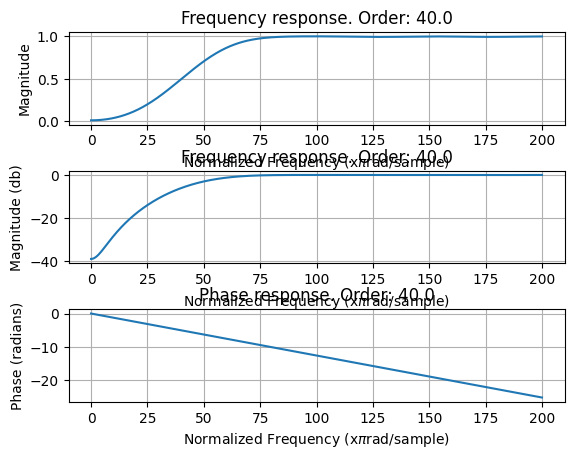

In [178]:
mfreqz(ca,1,order,200)

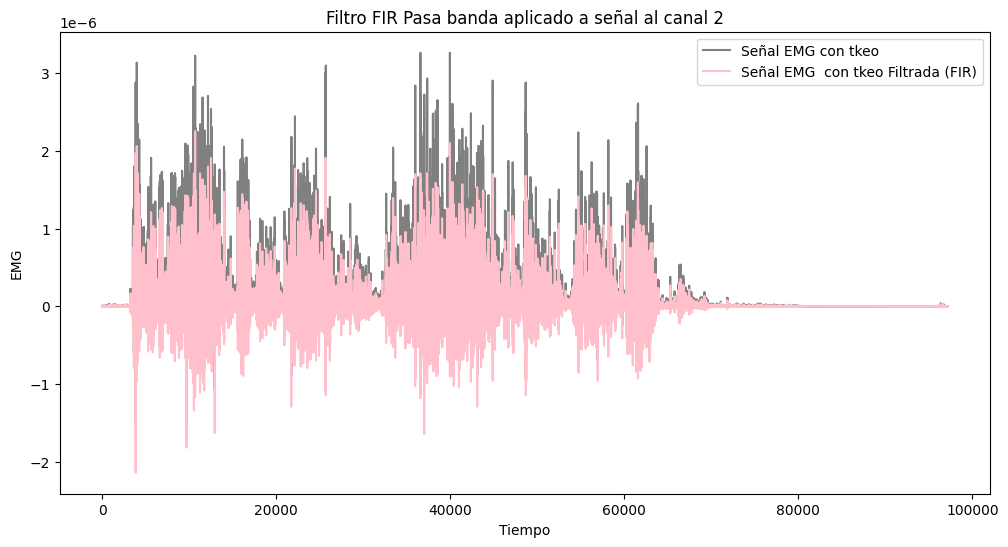

In [287]:
# Graficar la señal original y la señal filtrada por el filtro FIR
plt.figure(figsize=(12, 6))
plt.plot(todos_los_datos['tiempo'], tkeo_canal, color='gray', label='Señal EMG con tkeo')
plt.plot(todos_los_datos['tiempo'], filtrada1, color='pink', label='Señal EMG  con tkeo Filtrada (FIR)')
plt.title('Filtro FIR Pasa banda aplicado a señal al canal 2')
plt.xlabel('Tiempo')
plt.ylabel('EMG')
plt.legend()
plt.show()

**Para la función filter_FIR:**

*   Frecuencia de muestreo (fs) = 100 Hz
*   Frecuencia normalizada para bajas (wna) = 10 / (fs/2) = 0.2
*   Se obtuvo un orden de 40 - Un orden de 40 para el filtro FIR puede considerarse relativamente alto, lo que puede resultar en una mayor atenuación de las frecuencias no deseadas pero también en una mayor distorsión de la forma de onda de la señal.


---


 Este tipo de filtro es comúnmente utilizado para procesar señales digitales, la función permite especificar la frecuencia de muestreo y las frecuencias de corte para diseñar el filtro. Dependiendo de si se quiere un filtro para eliminar frecuencias bajas o altas, se pueden proporcionar una o dos frecuencias de corte. La función utiliza una técnica para calcular automáticamente el orden del filtro en función del ancho de la banda de transición. Luego, utiliza una ventana matemática llamada ventana de Hamming para calcular los coeficientes necesarios para el filtro.

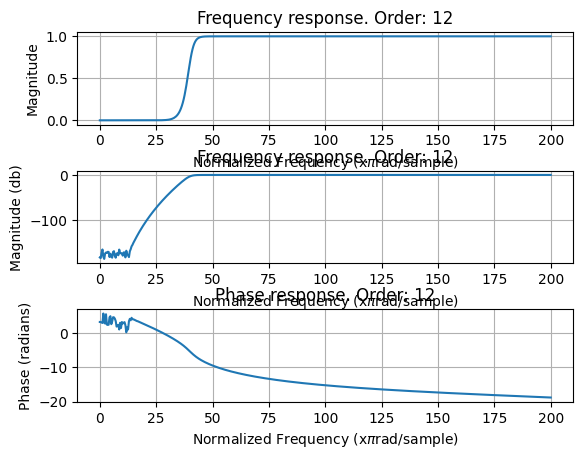

In [183]:
def filtro_IIR(senal_sin):

    fs_IR = 100  # Frecuencia de muestreo
    fn_IR = fs_IR / 2  # Frecuencia de Nyquist
    wna_IR = 10 / fn_IR  # Frecuencia normalizada para bajas

    # Orden del filtro
    order = 17

    # Diseño del filtro IIR pasa-altas
    bhpf, ahpf = signal.butter(order, wna_IR, btype='high', analog=False)

    # Filtrado de la señal
    senal_filtrada_1 = signal.filtfilt(bhpf, ahpf, senal_sin)  # Aplicar filtro pasa-altas

    return senal_filtrada_1, bhpf, ahpf, blpf, alpf

filtrada2, bhpf, ahpf, blpf, alpf = filtro_IIR(tkeo_canal)

mfreqz(bhpf, ahpf, 12, 200)

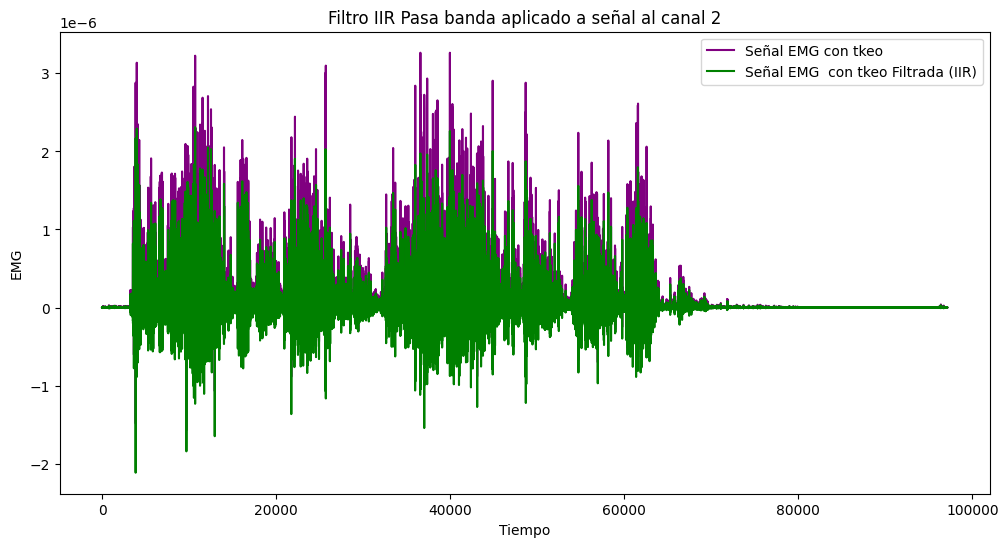

In [285]:
# Graficar la señal original y la señal filtrada por el filtro IIR
plt.figure(figsize=(12, 6))
plt.plot(todos_los_datos['tiempo'], tkeo_canal, color='purple', label='Señal EMG con tkeo')
plt.plot(todos_los_datos['tiempo'], filtrada2, color='green', label='Señal EMG  con tkeo Filtrada (IIR)')
plt.title('Filtro IIR Pasa banda aplicado a señal al canal 2')
plt.xlabel('Tiempo')
plt.ylabel('EMG')
plt.legend()
plt.show()

In [190]:
# Señal original
emg_original = tkeo_canal

# Señales filtradas
emg_fir = filtrada1
emg_iir = filtrada2

# Calcular Error Cuadrático Medio (MSE) y Coeficiente de Correlación
mse_fir = mean_squared_error(emg_original, emg_fir)
mse_iir = mean_squared_error(emg_original, emg_iir)

corr_fir, _ = pearsonr(emg_original, emg_fir)
corr_iir, _ = pearsonr(emg_original, emg_iir)

print("Filtro IIR:")
print(f"Error Cuadrático Medio (MSE): {mse_fir}")
print(f"Coeficiente de Correlación: {corr_fir}\n")

print("Filtro FIR:")
print(f"Error Cuadrático Medio (MSE): {mse_iir}")
print(f"Coeficiente de Correlación: {corr_iir}")

Filtro IIR:
Error Cuadrático Medio (MSE): 6.10545106054365e-16
Coeficiente de Correlación: 0.8145302192030586

Filtro FIR:
Error Cuadrático Medio (MSE): 5.905389515051768e-16
Coeficiente de Correlación: 0.8177898205480351


**Cónclusión:** Los resultados del estudio demostraron que el filtro FIR presentó un menor error cuadrático medio (ECM) y un mayor coeficiente de correlación en comparación con el filtro IIR. Esto indica que el filtro FIR fue más efectivo para eliminar el ruido y preservar la información relevante de la señal EMG, la superioridad del filtro FIR en este estudio se atribuye a que trata todas las frecuencias por igual, sin distorsiones ni alteraciones, además, el filtro FIR es computacionalmente más eficiente que el filtro IIR, lo que lo convierte en una mejor opción.



In [191]:
def apply_filtro(df):

    filtered_df = df.copy()  # Crear una copia del DataFrame original

    # Iterar sobre todas las columnas excepto la primera (índice) y la última (tiempo)
    for col in filtered_df.columns[2:-2]:

        # Crear una serie temporal a partir de la columna actual
        serie_temp = pd.Series(filtered_df[col].values, index=filtered_df['tiempo'])

        # Aplicar el filtro FIR a la serie temporal
        serie_filtrada, _ = filtro_FIR(serie_temp.values)

        # Asignar la serie filtrada a la columna correspondiente del DataFrame
        filtered_df[col] = serie_filtrada

    return filtered_df

df_filtro = apply_filtro(df_tkeo) # Datos aplicando el operador

display(df_filtro)

,tiempo,canal_1,canal_2,canal_3,canal_4,canal_5,canal_6,canal_7,canal_8,clase,sujeto
0,1,5.000000e-10,-7.663337e-14,-8.940559e-14,-1.149500e-13,1.148581e-27,1.856979e-27,-1.625053e-28,-6.721095e-28,0.0,1
1,5,2.000000e-10,8.051236e-10,5.433421e-10,1.278764e-09,-1.579143e-11,-1.206076e-10,-1.574150e-11,1.466800e-10,0.0,1
2,6,2.000000e-10,2.301998e-10,5.169249e-10,9.009786e-12,7.429574e-11,1.653175e-10,7.476993e-11,1.176270e-10,0.0,1
3,7,0.000000e+00,-1.808910e-10,-2.194678e-10,-1.635871e-10,-2.570837e-11,-3.372933e-11,-2.410400e-11,-7.806453e-11,0.0,1
4,8,0.000000e+00,-1.579136e-10,-2.045483e-10,-1.662193e-10,-1.989503e-11,-2.418620e-11,-1.639787e-11,-5.159663e-11,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
2195966,54832,0.000000e+00,7.419799e-11,5.363655e-10,-9.966892e-10,1.029734e-10,9.577956e-12,-7.193856e-12,0.000000e+00,0.0,36
2195967,54833,0.000000e+00,-3.974042e-11,2.009750e-10,-1.634246e-09,6.109799e-11,3.588838e-12,-2.520960e-11,0.000000e+00,0.0,36
2195968,54834,0.000000e+00,-3.129895e-10,-9.407719e-10,-1.664996e-09,-1.196635e-10,-1.679950e-11,-4.833152e-11,0.000000e+00,0.0,36
2195969,54835,0.000000e+00,-1.536742e-10,-2.965415e-09,1.029927e-08,-6.548265e-10,-5.295385e-11,1.252881e-10,0.000000e+00,0.0,36


In [193]:
def rms(signal):
    return np.sqrt(np.mean(np.square(signal)))

def variance(signal):
    return np.var(signal)

def mean_absolute_value(signal):
    return np.mean(np.abs(signal))

def mean_absolute_value_slope(signal):
    abs_diff = np.abs(np.diff(signal))
    return np.mean(abs_diff)

def slope_sign_changes(signal):
    diff = np.diff(signal)
    num_changes = np.sum(diff[:-1] * diff[1:] < 0)
    return num_changes

def wave_form_length(signal):
    abs_diff = np.abs(np.diff(signal))
    return np.sum(abs_diff)

def zero_crossings(signal):
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    return len(zero_crossings)

df_ordenado_filtro = df_filtro.sort_values(by='clase')

# Diccionario para almacenar los resultados
resultados_filtro = []

# Iterar sobre los grupos definidos por los valores de la columna 'clase'
for clase, grupo in df_ordenado_filtro.groupby('clase'):
    # Iterar sobre las columnas de interés (de la 2 a la 9)
    for columna in df_filtro.columns[1:9]:
        canal = grupo[columna]

        # Aplicar las características a cada canal
        caracteristicas = {
            'sujeto': grupo['sujeto'].iloc[0],  # Tomamos el valor del sujeto del primer elemento del grupo
            'clase': clase,
            'canal': columna,
            'rms':rms(canal),
            'variance': variance(canal),
            'mean_absolute_value': mean_absolute_value(canal),
            'mean_absolute_value_slope': mean_absolute_value_slope(canal),
            'slope_sign_changes': slope_sign_changes(canal),
            'wave_form_length': wave_form_length(canal),
            'zero_crossings': zero_crossings(canal)
        }

        # Añadir los resultados a la lista
        resultados_filtro.append(caracteristicas)

# Convertir la lista de diccionarios en un DataFrame
df_resultados_filtro = pd.DataFrame(resultados_filtro)

# El DataFrame df_resultados ahora contiene los resultados de las características para cada grupo de la columna 'clase', cada canal y sujeto.
display(df_resultados_filtro)  # Muestra las primeras filas del DataFrame de resultados

,sujeto,clase,canal,rms,variance,mean_absolute_value,mean_absolute_value_slope,slope_sign_changes,wave_form_length,zero_crossings
0,1,0.0,canal_1,5.710464e-08,3.242738e-15,4.859281e-09,7.497854e-09,162463,0.010781,265477
1,1,0.0,canal_2,3.026137e-08,9.157506e-16,3.433882e-09,5.063676e-09,638881,0.007281,514542
2,1,0.0,canal_3,2.958201e-08,8.750952e-16,3.978677e-09,5.870823e-09,638501,0.008442,514058
3,1,0.0,canal_4,5.881564e-08,3.459280e-15,1.075110e-08,1.591112e-08,639546,0.022879,515287
4,1,0.0,canal_5,7.109559e-08,5.054583e-15,1.524215e-08,2.257667e-08,641022,0.032463,516061
...,...,...,...,...,...,...,...,...,...,...
59,30,7.0,canal_4,1.488965e-08,2.217017e-16,4.862498e-09,7.132806e-09,3471,0.000051,2632
60,30,7.0,canal_5,8.777868e-08,7.705097e-15,3.308067e-08,5.085105e-08,3481,0.000360,2688
61,30,7.0,canal_6,8.191125e-08,6.709453e-15,2.715142e-08,4.238519e-08,3492,0.000300,2751
62,30,7.0,canal_7,5.271608e-09,2.778985e-17,1.822947e-09,2.801746e-09,3475,0.000020,2683


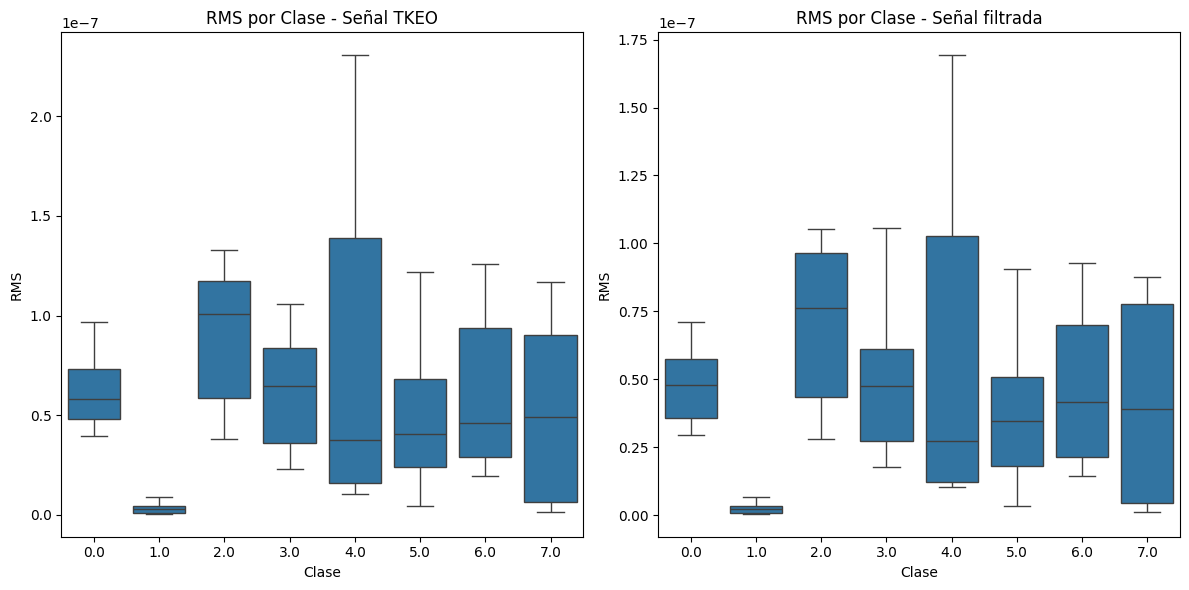

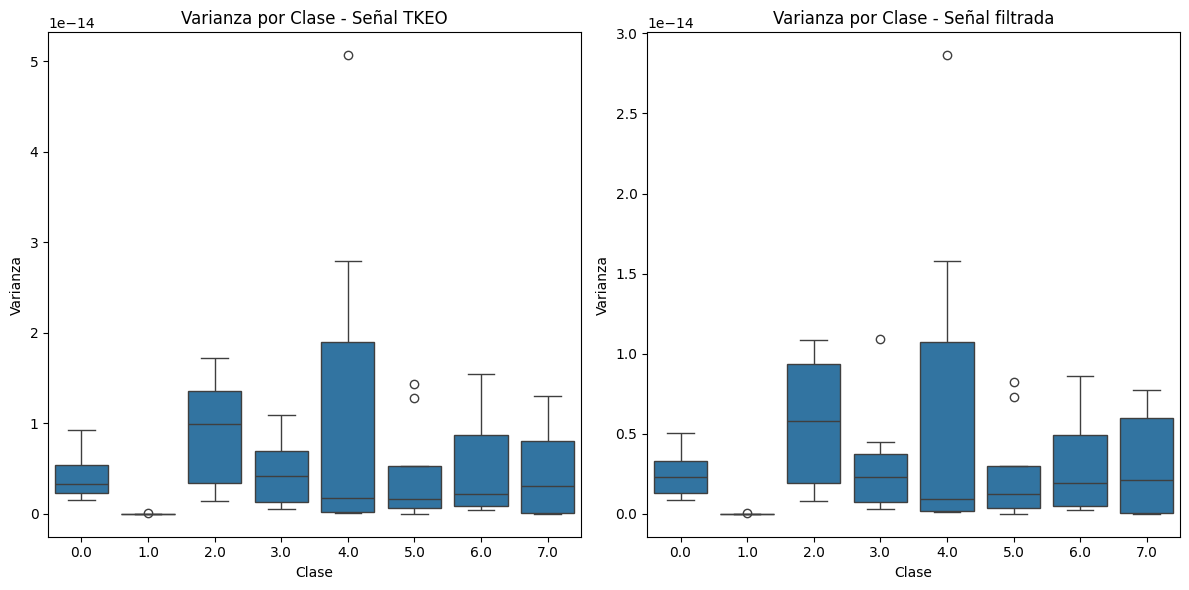

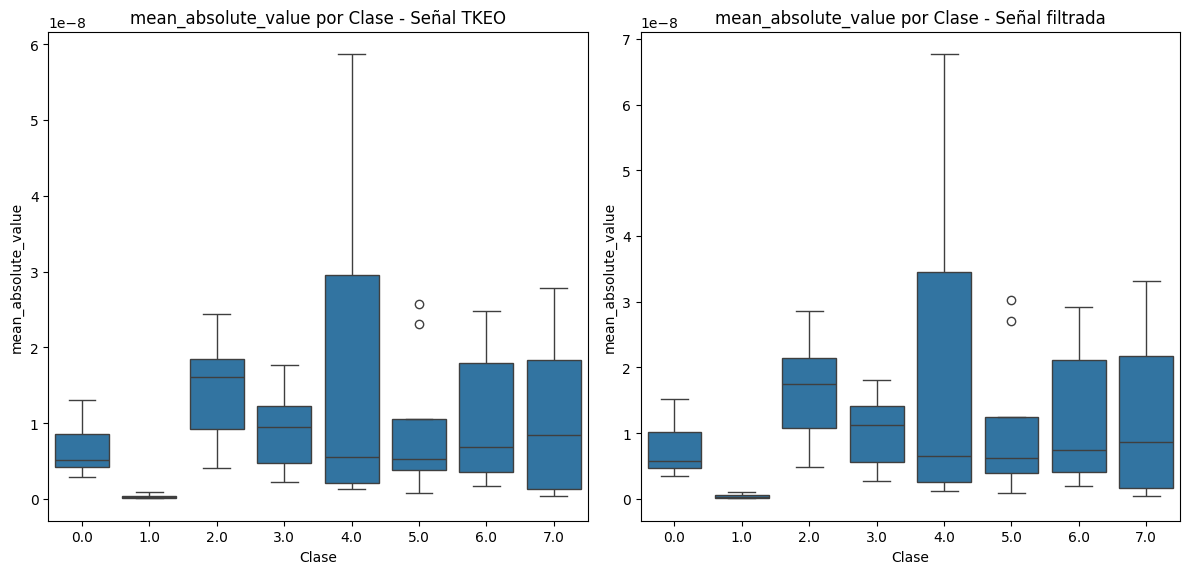

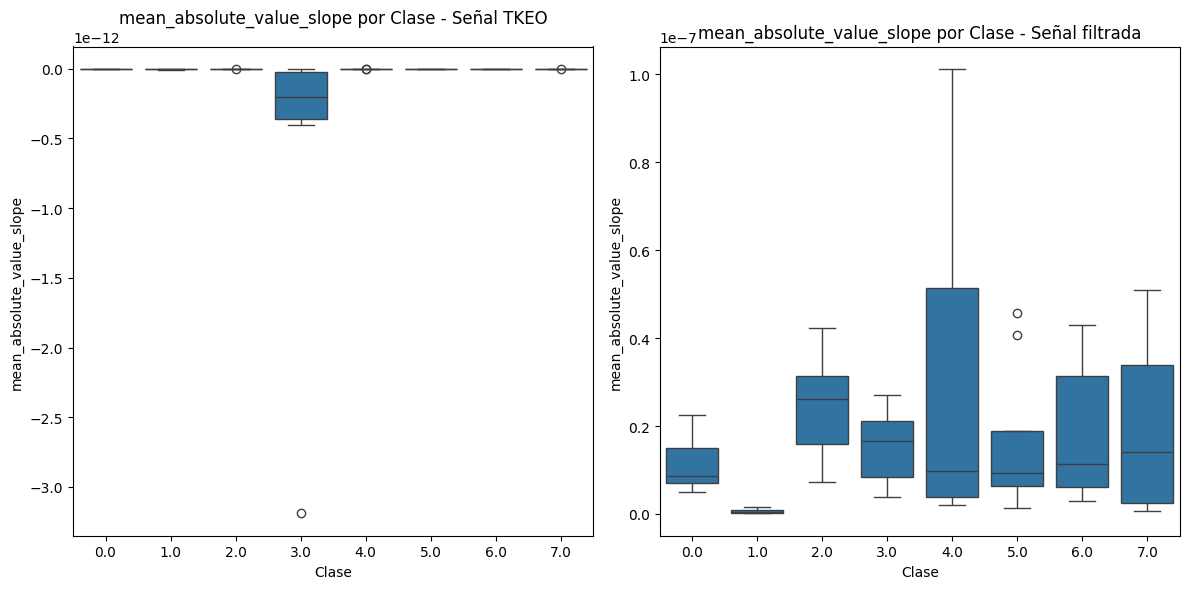

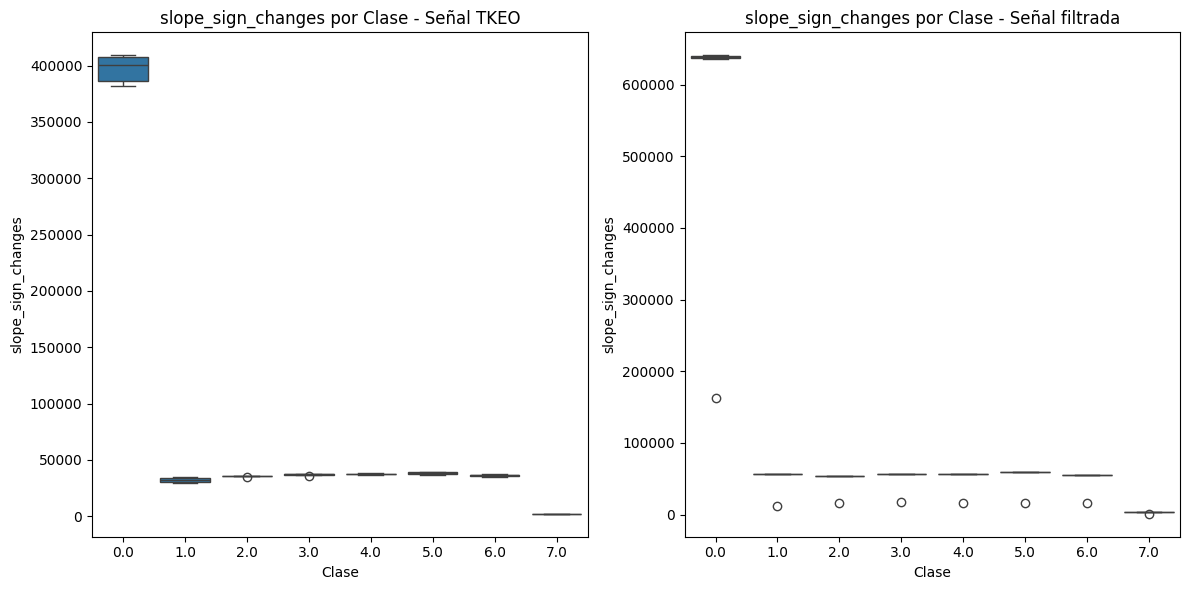

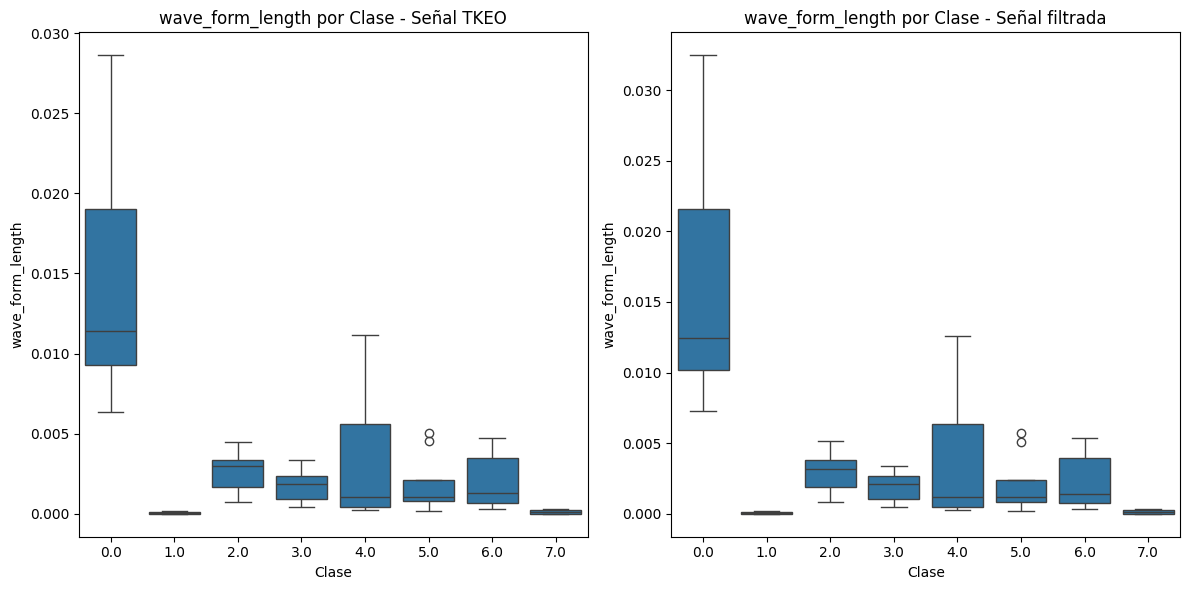

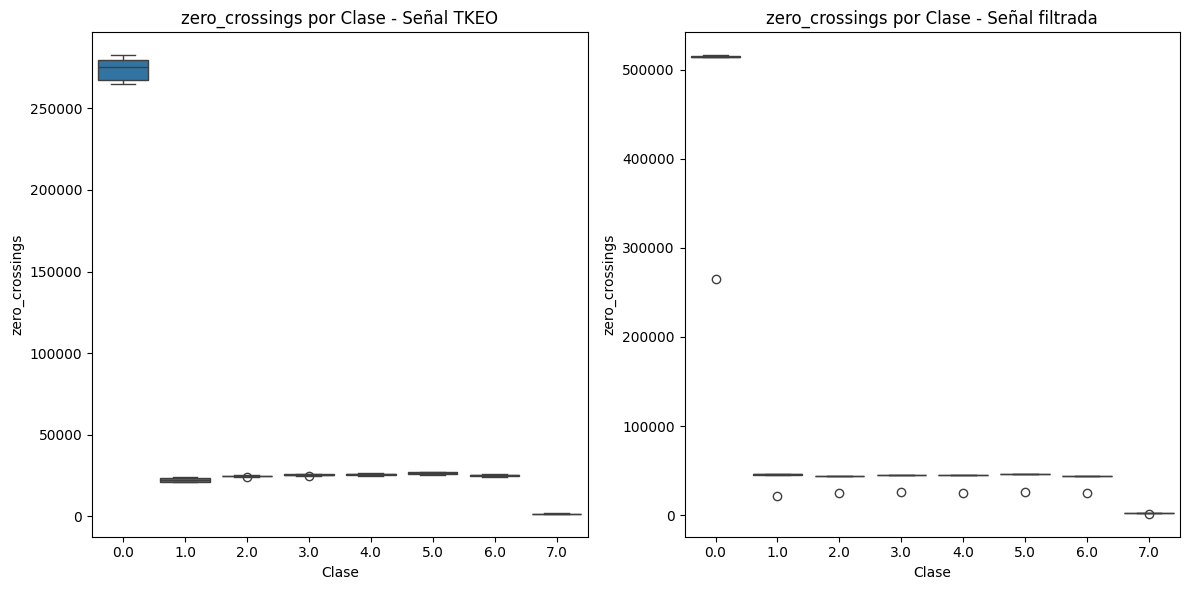

In [196]:
# Filtrar los datos para tener solo las métricas RMS y Varianza
metricas_tkeo = df_resultados_tkeo[['clase', 'rms', 'variance', 'mean_absolute_value', 'mean_absolute_value_slope', 'slope_sign_changes', 'wave_form_length', 'zero_crossings']]
metricas_filtro = df_resultados_filtro[['clase', 'rms', 'variance', 'mean_absolute_value', 'mean_absolute_value_slope', 'slope_sign_changes', 'wave_form_length', 'zero_crossings']]

# Crear diagramas de caja y bigotes para las métricas RMS y Varianza
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='clase', y='rms', data=metricas_tkeo )
plt.title('RMS por Clase - Señal TKEO')
plt.xlabel('Clase')
plt.ylabel('RMS')

plt.subplot(1, 2, 2)
sns.boxplot(x='clase', y='rms', data=metricas_filtro)
plt.title('RMS por Clase - Señal filtrada')
plt.xlabel('Clase')
plt.ylabel('RMS')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='clase', y='variance', data=metricas_tkeo)
plt.title('Varianza por Clase - Señal TKEO')
plt.xlabel('Clase')
plt.ylabel('Varianza')

plt.subplot(1, 2, 2)
sns.boxplot(x='clase', y='variance', data=metricas_filtro)
plt.title('Varianza por Clase - Señal filtrada')
plt.xlabel('Clase')
plt.ylabel('Varianza')

plt.tight_layout()
plt.show()

# Resto de las métricas
metricas_tkeo = df_resultados_tkeo[['clase', 'mean_absolute_value', 'mean_absolute_value_slope', 'slope_sign_changes', 'wave_form_length', 'zero_crossings']]
metricas_filtro = df_resultados_filtro[['clase', 'mean_absolute_value', 'mean_absolute_value_slope', 'slope_sign_changes', 'wave_form_length', 'zero_crossings']]

for metrica in metricas_tkeo.columns[1:]:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='clase', y=metrica, data=metricas_tkeo)
    plt.title(f'{metrica} por Clase - Señal TKEO')
    plt.xlabel('Clase')
    plt.ylabel(metrica)

    plt.subplot(1, 2, 2)
    sns.boxplot(x='clase', y=metrica, data=metricas_filtro)
    plt.title(f'{metrica} por Clase - Señal filtrada')
    plt.xlabel('Clase')
    plt.ylabel(metrica)

    plt.tight_layout()
    plt.show()

**Anáisis estadísticos:** Luego de examinar los diagramas de cajas y bigotes para comparar la señal TKEO original y la señal filtrada en términos de su comportamiento en diferentes métricas y movimientos, se revelaron diferencias notables en la distribución de los datos de movimiento para ambas señales en todas las métricas y luego, se realizaron pruebas estadísticas para determinar si existen diferencias significativas entre las señales.

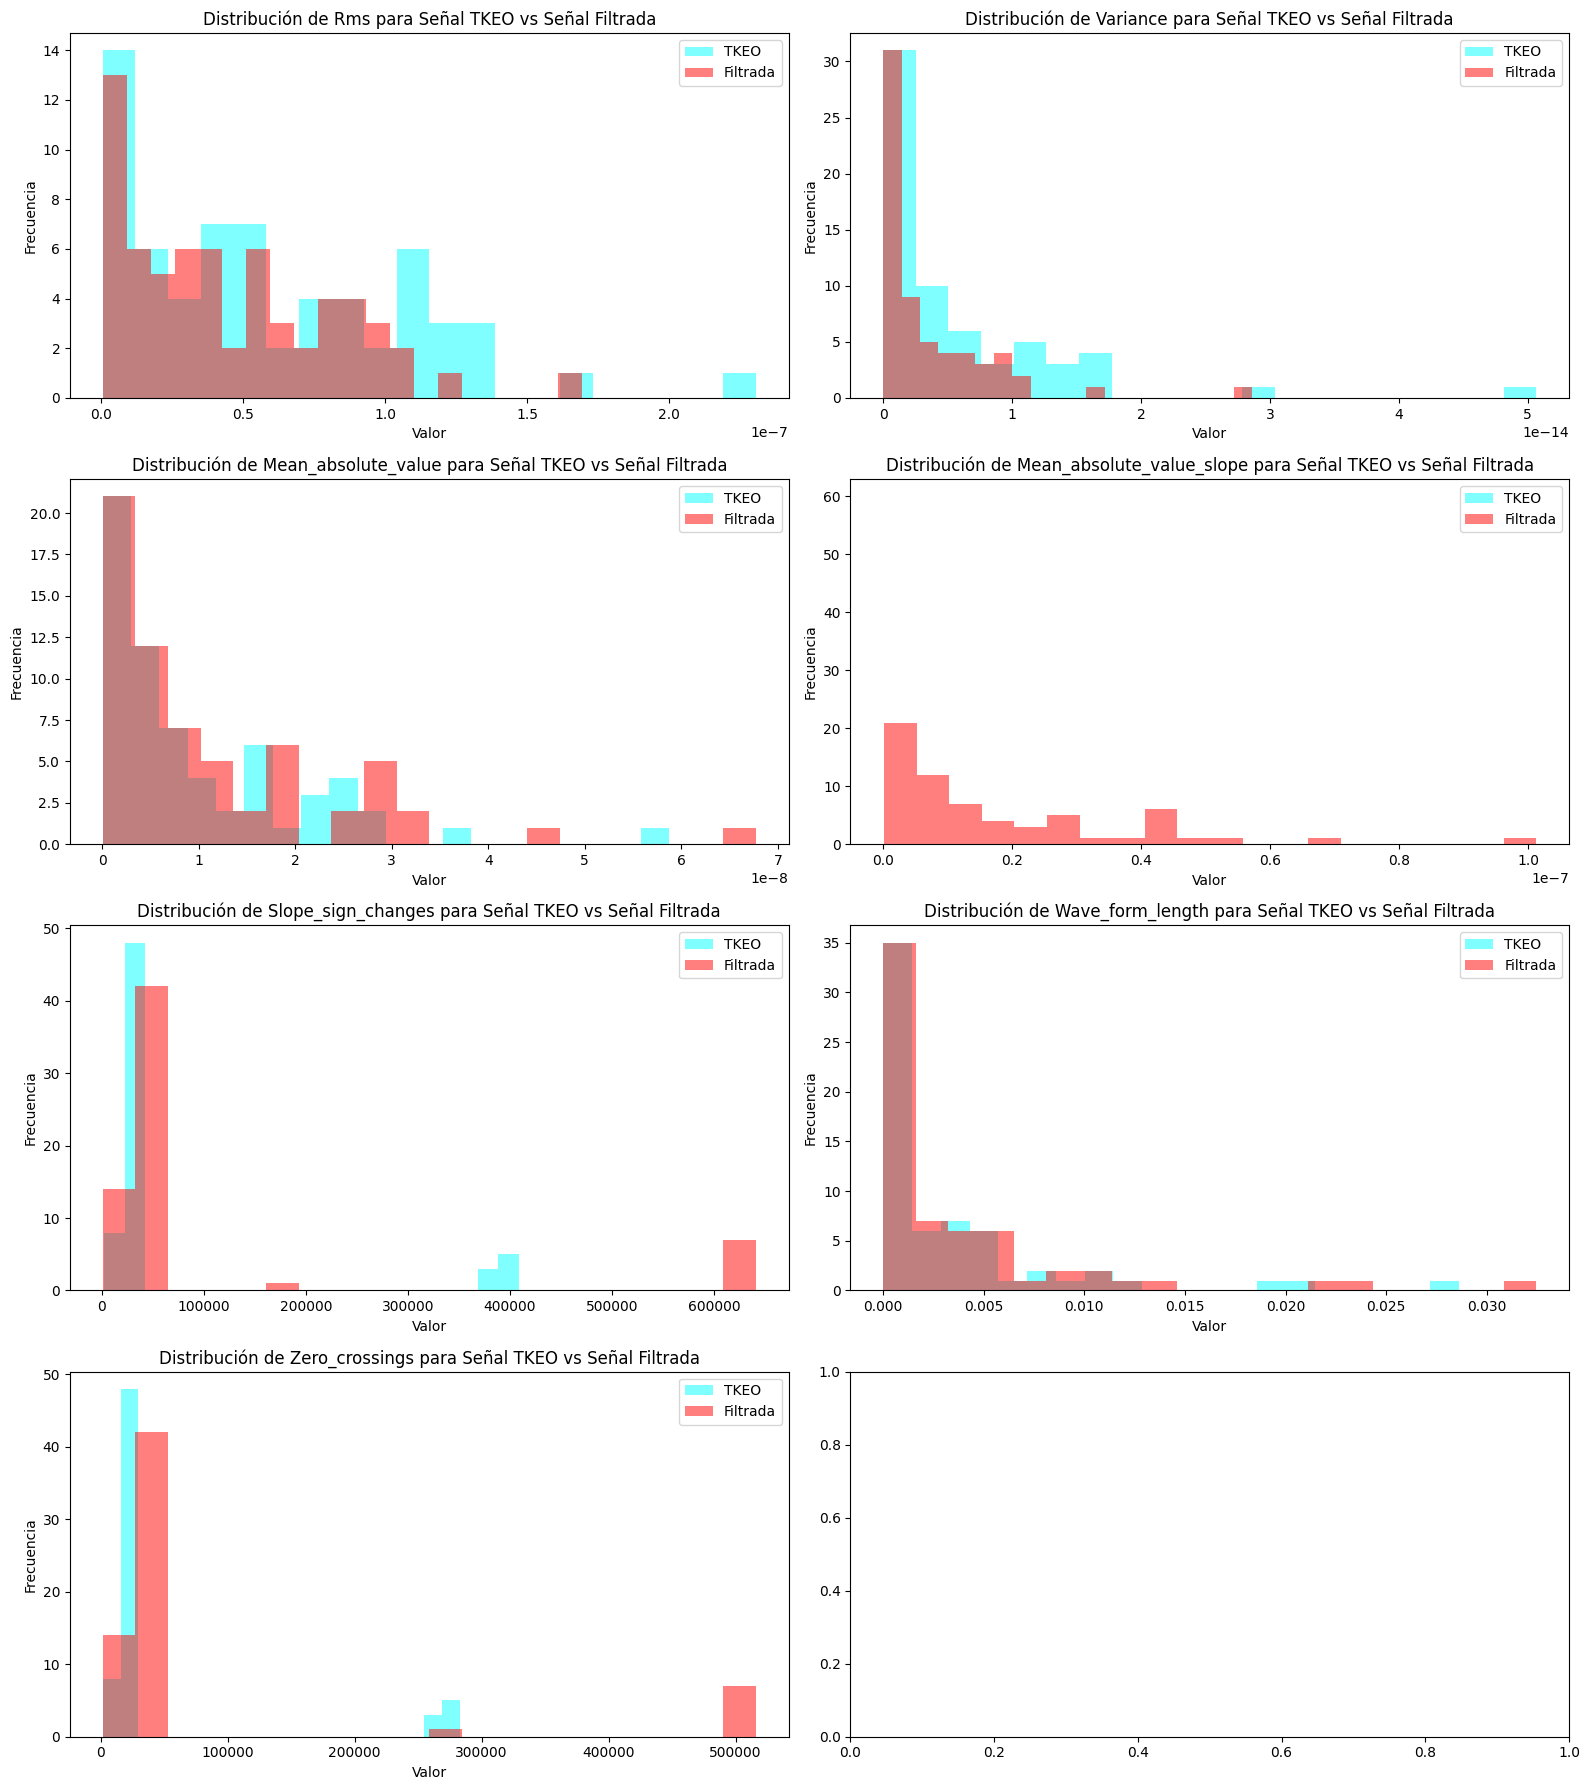

In [200]:
# Lista de índices para iterar
indices = ['rms', 'variance', 'mean_absolute_value', 'mean_absolute_value_slope', 'slope_sign_changes', 'wave_form_length', 'zero_crossings']

# Crear subplots
fig, axs = plt.subplots(4, 2, figsize=(16, 18))

# Iterar sobre cada índice y generar histogramas superpuestos
for i, idx in enumerate(indices):
    row = i // 2
    col = i % 2
    ax = axs[row, col]

    # Generar histograma para la señal TKEO
    ax.hist(df_resultados_tkeo[idx], bins=20, alpha=0.5, color='cyan', label='TKEO')

    # Generar histograma para la señal filtrada
    ax.hist(df_resultados_filtro[idx], bins=20, alpha=0.5, color='red', label='Filtrada')

    # Añadir etiquetas y título
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frecuencia')
    ax.set_title(f'Distribución de {idx.capitalize()} para Señal TKEO vs Señal Filtrada')
    ax.legend()

# Ajustar diseño
plt.tight_layout()
plt.show()

In [201]:
#para la señal TKEO
group = df_resultados_tkeo.groupby('clase')

clases = []
for clase, data_frame in group:
    clases.append(data_frame.values)
clase0 = group.get_group(0)
clase1 = group.get_group(1)
clase2 = group.get_group(2)
clase3 = group.get_group(3)
clase4 = group.get_group(4)
clase5 = group.get_group(5)
clase6 = group.get_group(6)
clase7 = group.get_group(7)

#para la señal TKEO filtrada
group_f = df_resultados_filtro.groupby('clase')

clase_ = []
for clase, data_frame in group:
    clase_.append(data_frame.values)
clase0_f = group_f.get_group(0)
clase1_f = group_f.get_group(1)
clase2_f = group_f.get_group(2)
clase3_f = group_f.get_group(3)
clase4_f = group_f.get_group(4)
clase5_f = group_f.get_group(5)
clase6_f = group_f.get_group(6)
clase7_f = group_f.get_group(7)

In [204]:
# Distribución de RMS con TKEO clase 0
rms_t= clase0.iloc[:,3]
shapiro_test = stats.shapiro(rms_t)
print("Prueba de Shapiro-Wilk para RMS:")
print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)
#Si el valor p es menor a 0.05 entonces se define como normal su distribución
if  shapiro_test.pvalue< 0.05:
  valor_p= 'Normal'

else:
  valor_p= 'No normal'

print(valor_p)

Prueba de Shapiro-Wilk para RMS:
Estadística de prueba: 0.940274178981781
Valor p: 0.6137802004814148
No normal


In [205]:
# Distribución de RMS con TKEO clase 1
rms_t1= clase1.iloc[:,3]
shapiro_test = stats.shapiro(rms_t1)
print("Prueba de Shapiro-Wilk para RMS:")
print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)
#Si el valor p es menor a 0.05 entonces se define como normal su distribución
if  shapiro_test.pvalue< 0.05:
  valor_p= 'Normal'

else:
  valor_p= 'No normal'

print(valor_p)

Prueba de Shapiro-Wilk para RMS:
Estadística de prueba: 0.8877192139625549
Valor p: 0.22283294796943665
No normal


In [206]:
# Distribución de variance con TKEO clase 0
variance_t= clase0.iloc[:,4]
shapiro_test = stats.shapiro(variance_t)
print("Prueba de Shapiro-Wilk para Var:")
print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)
#Si el valor p es menor a 0.05 entonces se define como normal su distribución
if  shapiro_test.pvalue< 0.05:
  valor_p= 'Normal'

else:
  valor_p= 'No normal'

print(valor_p)

Prueba de Shapiro-Wilk para Var:
Estadística de prueba: 0.8938233852386475
Valor p: 0.25388360023498535
No normal


In [207]:
# Distribución de mean_absolute_valuecon TKEO clase 1
mav_t= clase0.iloc[:,5]
shapiro_test = stats.shapiro(mav_t)
print("Prueba de Shapiro-Wilk para mean_absolute_value:")
print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)
#Si el valor p es menor a 0.05 entonces se define como normal su distribución
if  shapiro_test.pvalue< 0.05:
  valor_p= 'Normal'

else:
  valor_p= 'No normal'

print(valor_p)

Prueba de Shapiro-Wilk para mean_absolute_value:
Estadística de prueba: 0.8961969614028931
Valor p: 0.26691463589668274
No normal


In [208]:
# Distribución de mean_absolute_valuecon TKEO clase 1
mav_t1= clase1.iloc[:,5]
shapiro_test = stats.shapiro(mav_t1)
print("Prueba de Shapiro-Wilk para mean_absolute_value:")
print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)
#Si el valor p es menor a 0.05 entonces se define como normal su distribución
if  shapiro_test.pvalue< 0.05:
  valor_p= 'Normal'

else:
  valor_p= 'No normal'

print(valor_p)

Prueba de Shapiro-Wilk para mean_absolute_value:
Estadística de prueba: 0.8507657051086426
Valor p: 0.09698495268821716
No normal


In [209]:
# Distribución de wave_form_length TKEO clase 0
wfl_t= clase0.iloc[:,8]
shapiro_test = stats.shapiro(wfl_t)
print("Prueba de Shapiro-Wilk para slope_sign_changes:")
print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)
#Si el valor p es menor a 0.05 entonces se define como normal su distribución
if  shapiro_test.pvalue< 0.05:
  valor_p= 'Normal'

else:
  valor_p= 'No normal'

print(valor_p)

Prueba de Shapiro-Wilk para slope_sign_changes:
Estadística de prueba: 0.8994570374488831
Valor p: 0.2857222855091095
No normal


In [210]:
# Distribución de slope_sign_changes TKEO clase 1
wfl_t1= clase1.iloc[:,8]
shapiro_test = stats.shapiro(wfl_t1)
print("Prueba de Shapiro-Wilk para wave_form_length:")
print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)
#Si el valor p es menor a 0.05 entonces se define como normal su distribución
if  shapiro_test.pvalue< 0.05:
  valor_p= 'Normal'

else:
  valor_p= 'No normal'

print(valor_p)

Prueba de Shapiro-Wilk para wave_form_length:
Estadística de prueba: 0.8473457098007202
Valor p: 0.0895388051867485
No normal


In [211]:
# Distribución de RMS con TKEO  filtrada clase 0
rms_f= clase0_f.iloc[:,3]
shapiro_test = stats.shapiro(rms_f)
print("Prueba de Shapiro-Wilk para RMS:")
print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)
#Si el valor p es menor a 0.05 entonces se define como normal su distribución
if  shapiro_test.pvalue< 0.05:
  valor_p= 'Normal'

else:
  valor_p= 'No normal'

print(valor_p)

Prueba de Shapiro-Wilk para RMS:
Estadística de prueba: 0.9464344382286072
Valor p: 0.6752687692642212
No normal


In [212]:
# Distribución de RMS con TKEO  filtrada clase 1
rms_f1= clase1_f.iloc[:,3]
shapiro_test = stats.shapiro(rms_f1)
print("Prueba de Shapiro-Wilk para RMS:")
print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)
#Si el valor p es menor a 0.05 entonces se define como normal su distribución
if  shapiro_test.pvalue< 0.05:
  valor_p= 'Normal'

else:
  valor_p= 'No normal'

print(valor_p)

Prueba de Shapiro-Wilk para RMS:
Estadística de prueba: 0.8850728869438171
Valor p: 0.21042731404304504
No normal


In [213]:
# Distribución de variance con TKEO filtrada clase 0
variance_f= clase1.iloc[:,4]
shapiro_test = stats.shapiro(variance_f)
print("Prueba de Shapiro-Wilk para Var:")
print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)
#Si el valor p es menor a 0.05 entonces se define como normal su distribución
if  shapiro_test.pvalue< 0.05:
  valor_p= 'Normal'

else:
  valor_p= 'No normal'

print(valor_p)

Prueba de Shapiro-Wilk para Var:
Estadística de prueba: 0.7226612567901611
Valor p: 0.004053092561662197
Normal


In [214]:
# Distribución de variance con TKEO filtrada clase 1
variance_f1= clase1.iloc[:,4]
shapiro_test = stats.shapiro(variance_f1)
print("Prueba de Shapiro-Wilk para Var:")
print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)
#Si el valor p es menor a 0.05 entonces se define como normal su distribución
if  shapiro_test.pvalue< 0.05:
  valor_p= 'Normal'

else:
  valor_p= 'No normal'

print(valor_p)

Prueba de Shapiro-Wilk para Var:
Estadística de prueba: 0.7226612567901611
Valor p: 0.004053092561662197
Normal


In [215]:
# Distribución de mean_absolute_valuecon TKEO clase 0
mav_f= clase0_f.iloc[:,5]
shapiro_test = stats.shapiro(mav_f)
print("Prueba de Shapiro-Wilk para mean_absolute_value:")
print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)
#Si el valor p es menor a 0.05 entonces se define como normal su distribución
if  shapiro_test.pvalue< 0.05:
  valor_p= 'Normal'

else:
  valor_p= 'No normal'

print(valor_p)

Prueba de Shapiro-Wilk para mean_absolute_value:
Estadística de prueba: 0.884052038192749
Valor p: 0.20580539107322693
No normal


In [216]:
# Distribución de mean_absolute_valuecon TKEO clase 1
mav_f1= clase1_f.iloc[:,5]
shapiro_test = stats.shapiro(mav_f1)
print("Prueba de Shapiro-Wilk para mean_absolute_value:")
print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)
#Si el valor p es menor a 0.05 entonces se define como normal su distribución
if  shapiro_test.pvalue< 0.05:
  valor_p= 'Normal'

else:
  valor_p= 'No normal'

print(valor_p)

Prueba de Shapiro-Wilk para mean_absolute_value:
Estadística de prueba: 0.8586971759796143
Valor p: 0.11653421819210052
No normal


In [217]:
# Distribución de wave_form_length TKEO filtrada clase 0
wfl_f= clase0_f.iloc[:,8]
shapiro_test = stats.shapiro(wfl_f)
print("Prueba de Shapiro-Wilk para wave_form_length:")
print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)
#Si el valor p es menor a 0.05 entonces se define como normal su distribución
if  shapiro_test.pvalue< 0.05:
  valor_p= 'Normal'

else:
  valor_p= 'No normal'

print(valor_p)

Prueba de Shapiro-Wilk para wave_form_length:
Estadística de prueba: 0.8869949579238892
Valor p: 0.21937605738639832
No normal


In [218]:
# Distribución de wave_form_length TKEO filtrada clase 0
wfl_f1= clase1_f.iloc[:,8]
shapiro_test = stats.shapiro(wfl_f1)
print("Prueba de Shapiro-Wilk para wave_form_length:")
print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)
#Si el valor p es menor a 0.05 entonces se define como normal su distribución
if  shapiro_test.pvalue< 0.05:
  valor_p= 'Normal'

else:
  valor_p= 'No normal'

print(valor_p)

Prueba de Shapiro-Wilk para wave_form_length:
Estadística de prueba: 0.8544192314147949
Valor p: 0.10557623952627182
No normal


**Como ya en varios casos no se cumple uno de los supuestos (el que los datos distribuyen de manera normal), se decide no hacer la prueba de homecedasticidad, y se procede a realizar pruebas no paramétricas.**

**TKEO**

In [219]:
#Definición de todas las clases
rms_t2 = clase2.iloc[:,3]
rms_t3 = clase3.iloc[:,3]
rms_t4 = clase4.iloc[:,3]
rms_t5 = clase5.iloc[:,3]
rms_t6 = clase6.iloc[:,3]
rms_t7 = clase7.iloc[:,3]

In [220]:
kruskal_test = stats.kruskal(rms_t, rms_t1,rms_t2,rms_t3,rms_t4,rms_t5,rms_t6,rms_t7)  # Ejemplo comparando con canal_2_RMS
print("\nPrueba H de Kruskal-Wallispara comparar el RMS en cada clase de la señal tkeo:")
print("Estadística de prueba:", kruskal_test.statistic)
print("Valor p:", kruskal_test.pvalue)

# Interpretación del p-valor
alpha = 0.05  # Nivel de significancia
if kruskal_test.pvalue < alpha:
    print("Hay una diferencia significativa entre las métricas.")
else:
    print("No hay una diferencia significativa entre las métricas.")


Prueba H de Kruskal-Wallispara comparar el RMS en cada clase de la señal tkeo:
Estadística de prueba: 23.31274038461541
Valor p: 0.0015034206196435508
Hay una diferencia significativa entre las métricas.


In [224]:
variance_t2 = clase2.iloc[:,4]
variance_t3 = clase3.iloc[:,4]
variance_t4 = clase4.iloc[:,4]
variance_t5 = clase5.iloc[:,4]
variance_t6 = clase6.iloc[:,4]
variance_t7 = clase7.iloc[:,4]

In [223]:
kruskal_test = stats.kruskal(variance_t,variance_t2,variance_t3,variance_t4,variance_t5,variance_t6, variance_t7)  # Ejemplo comparando con canal_2_RMS
print("\nPrueba de kruskal para comparar clase0_variance con clase1_variance en la señal tkeo:")
print("Estadística de prueba:", kruskal_test.statistic)
print("Valor p:", kruskal_test.pvalue)

# Interpretación del p-valor
alpha = 0.05  # Nivel de significancia
if kruskal_test.pvalue < alpha:
    print("Hay una diferencia significativa entre las métricas.")
else:
    print("No hay una diferencia significativa entre las métricas.")


Prueba de kruskal para comparar clase0_variance con clase1_variance en la señal tkeo:
Estadística de prueba: 5.56390977443607
Valor p: 0.47376624312239757
No hay una diferencia significativa entre las métricas.


In [225]:
mav_t2 = clase2.iloc[:,5]
mav_t3 = clase3.iloc[:,5]
mav_t4 = clase4.iloc[:,5]
mav_t5 = clase5.iloc[:,5]
mav_t6 = clase6.iloc[:,5]
mav_t7 = clase7.iloc[:,5]

In [226]:
kruskal_test = stats.kruskal(mav_t, mav_t1,mav_t2,mav_t3,mav_t4,mav_t5,mav_t6,mav_t7)  # Ejemplo comparando con canal_2_RMS
print("\nPrueba de kruskal para comparar Mean_absolute_valuecon de los movimientos en la señal tkeo:")
print("Estadística de prueba:", kruskal_test.statistic)
print("Valor p:", kruskal_test.pvalue)

# Interpretación del p-valor
alpha = 0.05  # Nivel de significancia
if kruskal_test.pvalue < alpha:
    print("Hay una diferencia significativa entre las métricas.")
else:
    print("No hay una diferencia significativa entre las métricas.")


Prueba de kruskal para comparar Mean_absolute_valuecon de los movimientos en la señal tkeo:
Estadística de prueba: 22.910336538461564
Valor p: 0.0017669823252081057
Hay una diferencia significativa entre las métricas.


In [227]:
mavs_t = clase0.iloc[:,6]
mavs_t1 = clase1.iloc[:,6]
mavs_t2 = clase2.iloc[:,6]
mavs_t3 = clase3.iloc[:,6]
mavs_t4 = clase4.iloc[:,6]
mavs_t5 = clase5.iloc[:,6]
mavs_t6 = clase6.iloc[:,6]
mavs_t7 = clase7.iloc[:,6]

In [228]:
kruskal_test = stats.kruskal(mavs_t, mavs_t1,mavs_t2,mavs_t3,mavs_t4,mavs_t5,mavs_t6,mavs_t7)  # Ejemplo comparando con canal_2_RMS
print("\nPrueba de kruskal para comparar Mean_absolute_valuecon de los movimientos en la señal tkeo:")
print("Estadística de prueba:", kruskal_test.statistic)
print("Valor p:", kruskal_test.pvalue)

# Interpretación del p-valor
alpha = 0.05  # Nivel de significancia
if kruskal_test.pvalue < alpha:
    print("Hay una diferencia significativa entre las métricas.")
else:
    print("No hay una diferencia significativa entre las métricas.")


Prueba de kruskal para comparar Mean_absolute_valuecon de los movimientos en la señal tkeo:
Estadística de prueba: 27.405288461538476
Valor p: 0.0002816839390006209
Hay una diferencia significativa entre las métricas.


In [229]:
ssc_t = clase0.iloc[:,7]
ssc_t1 = clase1.iloc[:,7]
ssc_t2 = clase2.iloc[:,7]
ssc_t3 = clase3.iloc[:,7]
ssc_t4 = clase4.iloc[:,7]
ssc_t5 = clase5.iloc[:,7]
ssc_t6 = clase6.iloc[:,7]
ssc_t7 = clase7.iloc[:,7]

In [230]:
kruskal_test = stats.kruskal(ssc_t, ssc_t1, ssc_t2, ssc_t3, ssc_t4, ssc_t5, ssc_t6, ssc_t7 )  # Ejemplo comparando con canal_2_RMS
print("\nPrueba de kruskal para comparar _Slop sing changes_ de los moviminetos en la señal tkeo:")
print("Estadística de prueba:", kruskal_test.statistic)
print("Valor p:", kruskal_test.pvalue)

# Interpretación del p-valor
alpha = 0.05  # Nivel de significancia
if kruskal_test.pvalue < alpha:
    print("Hay una diferencia significativa entre las métricas.")
else:
    print("No hay una diferencia significativa entre las métricas.")


Prueba de kruskal para comparar _Slop sing changes_ de los moviminetos en la señal tkeo:
Estadística de prueba: 57.785336538461564
Valor p: 4.1718568122018417e-10
Hay una diferencia significativa entre las métricas.


In [231]:
wfl_t2 = clase2.iloc[:,8]
wfl_t3 = clase3.iloc[:,8]
wfl_t4 = clase4.iloc[:,8]
wfl_t5 = clase5.iloc[:,8]
wfl_t6 = clase6.iloc[:,8]
wfl_t7 = clase7.iloc[:,8]

In [232]:
kruskal_test = stats.kruskal(wfl_t, wfl_t1, wfl_t2, wfl_t3, wfl_t4, wfl_t5, wfl_t6, wfl_t7 )  # Ejemplo comparando con canal_2_RMS
print("\nPrueba de kruskal para comparar _Wave form lengt_ de los moviminetos en la señal tkeo:")
print("Estadística de prueba:", kruskal_test.statistic)
print("Valor p:", kruskal_test.pvalue)

# Interpretación del p-valor
alpha = 0.05  # Nivel de significancia
if kruskal_test.pvalue < alpha:
    print("Hay una diferencia significativa entre las métricas.")
else:
    print("No hay una diferencia significativa entre las métricas.")


Prueba de kruskal para comparar _Wave form lengt_ de los moviminetos en la señal tkeo:
Estadística de prueba: 45.55168269230771
Valor p: 1.0685604758039166e-07
Hay una diferencia significativa entre las métricas.


In [233]:
zc_t = clase0.iloc[:,9]
zc_t1 = clase1.iloc[:,9]
zc_t2 = clase2.iloc[:,9]
zc_t3 = clase3.iloc[:,9]
zc_t4 = clase4.iloc[:,9]
zc_t5 = clase5.iloc[:,9]
zc_t6 = clase6.iloc[:,9]
zc_t7 = clase7.iloc[:,9]

In [234]:
kruskal_test = stats.kruskal(zc_t, zc_t1, zc_t2, zc_t3, zc_t4, zc_t5, zc_t6, zc_t7 )  # Ejemplo comparando con canal_2_RMS
print("\nPrueba de kruskal para comparar _Zero crossing_ de los moviminetos en la señal tkeo:")
print("Estadística de prueba:", kruskal_test.statistic)
print("Valor p:", kruskal_test.pvalue)

# Interpretación del p-valor
alpha = 0.05  # Nivel de significancia
if kruskal_test.pvalue < alpha:
    print("Hay una diferencia significativa entre las métricas.")
else:
    print("No hay una diferencia significativa entre las métricas.")



Prueba de kruskal para comparar _Zero crossing_ de los moviminetos en la señal tkeo:
Estadística de prueba: 54.81274038461541
Valor p: 1.6238554649035137e-09
Hay una diferencia significativa entre las métricas.


**FILTRADA**

In [235]:
#Definición de todas las clases
rms_f2 = clase2_f.iloc[:,3]
rms_f3 = clase3_f.iloc[:,3]
rms_f4 = clase4_f.iloc[:,3]
rms_f5 = clase5_f.iloc[:,3]
rms_f6 = clase6_f.iloc[:,3]
rms_f7 = clase7_f.iloc[:,3]

In [236]:
kruskal_test = stats.kruskal(rms_f, rms_f1,rms_f2,rms_f3,rms_f4,rms_f5,rms_f6,rms_f7)  # Ejemplo comparando con canal_2_RMS
print("\nPrueba kruskalpara comparar RMS de los movimientos en la señal tkeo filtrada:")
print("Estadística de prueba:", kruskal_test.statistic)
print("Valor p:", kruskal_test.pvalue)

# Interpretación del p-valor
alpha = 0.05  # Nivel de significancia
if kruskal_test.pvalue < alpha:
    print("Hay una diferencia significativa entre las métricas.")
else:
    print("No hay una diferencia significativa entre las métricas.")


Prueba kruskalpara comparar RMS de los movimientos en la señal tkeo filtrada:
Estadística de prueba: 22.636298076923083
Valor p: 0.0019717368015287336
Hay una diferencia significativa entre las métricas.


In [237]:
variance_f2 = clase2_f.iloc[:,4]
variance_f3 = clase3_f.iloc[:,4]
variance_f4 = clase4_f.iloc[:,4]
variance_f5 = clase5_f.iloc[:,4]
variance_f6 = clase6_f.iloc[:,4]
variance_f7 = clase7_f.iloc[:,4]

In [242]:
kruskal_test = stats.kruskal(variance_f, variance_f1,variance_f2,variance_f3,variance_f4,variance_f5,variance_f6, variance_f7)  # Ejemplo comparando con canal_2_RMS
print("\nPrueba de kruskal para comparar variance de los movimientos en la señal tkeo filtrada:")
print("Estadística de prueba:", kruskal_test.statistic)
print("Valor p:", kruskal_test.pvalue)

# Interpretación del p-valor
alpha = 0.05  # Nivel de significancia
if kruskal_test.pvalue < alpha:
    print("No hay una diferencia significativa entre las métricas.")
else:
    print("Hay una diferencia significativa entre las métricas.")


Prueba de kruskal para comparar variance de los movimientos en la señal tkeo filtrada:
Estadística de prueba: 33.46117649752702
Valor p: 2.1719959961788564e-05
No hay una diferencia significativa entre las métricas.


In [239]:
mav_f2 = clase2_f.iloc[:,5]
mav_f3 = clase3_f.iloc[:,5]
mav_f4 = clase4_f.iloc[:,5]
mav_f5 = clase5_f.iloc[:,5]
mav_f6 = clase6_f.iloc[:,5]
mav_f7 = clase7_f.iloc[:,5]

In [243]:
kruskal_test = stats.kruskal(mav_f, mav_f1,mav_f2,mav_f3,mav_f4,mav_f5,mav_f6,mav_f7)  # Ejemplo comparando con canal_2_RMS
print("\nPrueba de kruskal para comparar Mean_absolute_valuecon de los movimientos en la señal tkeo:")
print("Estadística de prueba:", kruskal_test.statistic)
print("Valor p:", kruskal_test.pvalue)

# Interpretación del p-valor
alpha = 0.05  # Nivel de significancia
if kruskal_test.pvalue < alpha:
    print("Hay una diferencia significativa entre las métricas.")
else:
    print("No hay una diferencia significativa entre las métricas.")


Prueba de kruskal para comparar Mean_absolute_valuecon de los movimientos en la señal tkeo:
Estadística de prueba: 22.649278846153862
Valor p: 0.001961536208638241
Hay una diferencia significativa entre las métricas.


In [244]:
mavs_f = clase0_f.iloc[:,6]
mavs_f1 = clase1_f.iloc[:,6]
mavs_f2 = clase2_f.iloc[:,6]
mavs_f3 = clase3_f.iloc[:,6]
mavs_f4 = clase4_f.iloc[:,6]
mavs_f5 = clase5_f.iloc[:,6]
mavs_f6 = clase6_f.iloc[:,6]
mavs_f7 = clase7_f.iloc[:,6]

In [245]:
kruskal_test = stats.kruskal(mavs_f, mavs_f1,mavs_f2,mavs_f3,mavs_f4,mavs_f5,mavs_f6,mavs_f7)  # Ejemplo comparando con canal_2_RMS
print("\nPrueba de kruskal para comparar Mean_absolute_value slope con de los movimientos en la señal tkeo:")
print("Estadística de prueba:", kruskal_test.statistic)
print("Valor p:", kruskal_test.pvalue)

# Interpretación del p-valor
alpha = 0.05  # Nivel de significancia
if kruskal_test.pvalue < alpha:
    print("Hay una diferencia significativa entre las métricas.")
else:
    print("No hay una diferencia significativa entre las métricas.")


Prueba de kruskal para comparar Mean_absolute_value slope con de los movimientos en la señal tkeo:
Estadística de prueba: 22.48701923076925
Valor p: 0.00209282499683075
Hay una diferencia significativa entre las métricas.


In [246]:
ssc_f = clase0_f.iloc[:,7]
ssc_f1 = clase1_f.iloc[:,7]
ssc_f2 = clase2_f.iloc[:,7]
ssc_f3 = clase3_f.iloc[:,7]
ssc_f4 = clase4_f.iloc[:,7]
ssc_f5 = clase5_f.iloc[:,7]
ssc_f6 = clase6_f.iloc[:,7]
ssc_f7 = clase7_f.iloc[:,7]

In [247]:
kruskal_test = stats.kruskal(ssc_f, ssc_f1, ssc_f2, ssc_f3, ssc_f4, ssc_f5, ssc_f6, ssc_f7 )  # Ejemplo comparando con canal_2_RMS
print("\nPrueba de kruskal para comparar _Slop sing changes_ de los moviminetos en la señal tkeo:")
print("Estadística de prueba:", kruskal_test.statistic)
print("Valor p:", kruskal_test.pvalue)

# Interpretación del p-valor
alpha = 0.05  # Nivel de significancia
if kruskal_test.pvalue < alpha:
    print("Hay una diferencia significativa entre las métricas.")
else:
    print("No hay una diferencia significativa entre las métricas.")


Prueba de kruskal para comparar _Slop sing changes_ de los moviminetos en la señal tkeo:
Estadística de prueba: 50.84062500000002
Valor p: 9.875216023883993e-09
Hay una diferencia significativa entre las métricas.


In [248]:
wfl_f2 = clase2_f.iloc[:,8]
wfl_f3 = clase3_f.iloc[:,8]
wfl_f4 = clase4_f.iloc[:,8]
wfl_f5 = clase5_f.iloc[:,8]
wfl_f6 = clase6_f.iloc[:,8]
wfl_f7 = clase7_f.iloc[:,8]

In [252]:
kruskal_test = stats.kruskal(wfl_f, wfl_f1, wfl_f2, wfl_f3, wfl_f4, wfl_f5, wfl_f6, wfl_f7 )  # Ejemplo comparando con canal_2_RMS
print("\nPrueba de kruskal para comparar _Wave form lengt_ de los moviminetos en la señal tkeo:")
print("Estadística de prueba:", kruskal_test.statistic)
print("Valor p:", kruskal_test.pvalue)

# Interpretación del p-valor
alpha = 0.05  # Nivel de significancia
if kruskal_test.pvalue < alpha:
    print("Hay una diferencia significativa entre las métricas.")
else:
    print("No hay una diferencia significativa entre las métricas.")


Prueba de kruskal para comparar _Wave form lengt_ de los moviminetos en la señal tkeo:
Estadística de prueba: 45.579807692307696
Valor p: 1.0551934588313216e-07
Hay una diferencia significativa entre las métricas.


 Los resultados mostraron que, en ambos casos, dos parámetros, la varianza y el zero crossing, no presentaron capacidad significativa para distinguir estadísticamente entre los diferentes movimientos, por otro lado, los cinco parámetros restantes demostraron ser efectivos para diferenciar los movimientos realizados y de esos solamente escogí 3 dejándome guiar por lo visto en los diagramas de caja y bigotes, con estos resultados se puede afirmar que tanto la señal TKEO como la señal filtrada son válidas para el diseño de modelos de aprendizaje automático, ya que presentan patrones y tendencias similares, sin embargo, es importante destacar que el parámetro "wl" no parece ser un factor discriminante significativo para diferenciar entre los distintos movimientos o clases evaluadas, por lo tanto, se recomienda considerar los 3 parámetros efectivos para cada tipo de señal al diseñar el modelo de aprendizaje automático.

**REDES NEURONALES**

In [253]:
df_resultados_filtro.describe()

,sujeto,clase,rms,variance,mean_absolute_value,mean_absolute_value_slope,slope_sign_changes,wave_form_length,zero_crossings
count,64.000000,64.000000,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,64.000000,64.000000,64.000000
mean,16.250000,3.500000,4.483032e-08,3.362882e-15,1.138166e-08,1.708073e-08,111220.718750,0.003659,92652.796875
std,12.484912,2.309401,3.721073e-08,4.806440e-15,1.265760e-08,1.897063e-08,187959.029378,0.005975,152491.410402
min,1.000000,0.000000,5.492973e-10,3.017275e-19,7.035778e-11,1.149142e-10,1014.000000,0.000005,1599.000000
25%,5.750000,1.750000,1.329144e-08,1.769465e-16,2.423541e-09,3.606980e-09,54008.000000,0.000238,43628.250000
50%,13.500000,3.500000,3.859335e-08,1.480637e-15,6.560669e-09,9.823220e-09,56116.500000,0.001329,44959.500000
75%,27.000000,5.250000,7.015998e-08,4.922714e-15,1.778526e-08,2.696061e-08,56976.500000,0.004694,46017.000000
max,35.000000,7.000000,1.692172e-07,2.863447e-14,6.772510e-08,1.012464e-07,641022.000000,0.032463,516061.000000


In [254]:
df_resultados_filtro.drop(columns=['clase']).describe()

,sujeto,rms,variance,mean_absolute_value,mean_absolute_value_slope,slope_sign_changes,wave_form_length,zero_crossings
count,64.000000,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,64.000000,64.000000,64.000000
mean,16.250000,4.483032e-08,3.362882e-15,1.138166e-08,1.708073e-08,111220.718750,0.003659,92652.796875
std,12.484912,3.721073e-08,4.806440e-15,1.265760e-08,1.897063e-08,187959.029378,0.005975,152491.410402
min,1.000000,5.492973e-10,3.017275e-19,7.035778e-11,1.149142e-10,1014.000000,0.000005,1599.000000
25%,5.750000,1.329144e-08,1.769465e-16,2.423541e-09,3.606980e-09,54008.000000,0.000238,43628.250000
50%,13.500000,3.859335e-08,1.480637e-15,6.560669e-09,9.823220e-09,56116.500000,0.001329,44959.500000
75%,27.000000,7.015998e-08,4.922714e-15,1.778526e-08,2.696061e-08,56976.500000,0.004694,46017.000000
max,35.000000,1.692172e-07,2.863447e-14,6.772510e-08,1.012464e-07,641022.000000,0.032463,516061.000000


In [273]:
# Step 3 - Creating Arrays for the Features and the Response Variable
target_column = ['clase']  # Nombre de la columna que contiene la clase
predictors = ['rms', 'mean_absolute_value', 'mean_absolute_value_slope']  # Nombres de las características a utilizar
print(predictors)

# Normalizar las características
df_resultados_filtro[predictors] = df_resultados_filtro[predictors] / df_resultados_filtro[predictors].max()

# Descripción estadística excluyendo la columna 'clase'
df_describe = df_resultados_filtro.drop(columns=target_column).describe()

# Ver los primeros registros de la descripción
display(df_describe.head())

['rms', 'mean_absolute_value', 'mean_absolute_value_slope']


,sujeto,rms,variance,mean_absolute_value,mean_absolute_value_slope,slope_sign_changes,wave_form_length,zero_crossings
count,64.000000,64.000000,6.400000e+01,64.000000,64.000000,64.000000,64.000000,64.000000
mean,16.250000,0.264928,3.362882e-15,0.168057,0.168704,111220.718750,0.003659,92652.796875
std,12.484912,0.219899,4.806440e-15,0.186897,0.187371,187959.029378,0.005975,152491.410402
min,1.000000,0.003246,3.017275e-19,0.001039,0.001135,1014.000000,0.000005,1599.000000
25%,5.750000,0.078547,1.769465e-16,0.035785,0.035626,54008.000000,0.000238,43628.250000


In [262]:
#%% Step 4 - Creating the Training and Test Datasets
X = df_resultados_filtro[predictors].values
y = df_resultados_filtro[target_column].values

#the same seed is used to partition to obtain the same results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(44, 3)
(44,)
(20, 3)
(20,)


In [268]:
# Definir los nombres de las clases
target_names = ['clase0', 'clase1', 'clase2', 'clase3', 'clase4', 'clase5', 'clase6', 'clase7']

In [269]:
# Crear y entrenar el modelo de red neuronal
mlp = MLPClassifier(hidden_layer_sizes=(8, 8, 8), activation='relu', solver='adam', max_iter=1000)
mlp.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=1000)

In [275]:
# Predecir las etiquetas para el conjunto de entrenamiento y prueba
predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

In [274]:
# Mostrar la matriz de confusión y el informe de clasificación para el conjunto de entrenamiento
print(confusion_matrix(y_train, predict_train))
print(classification_report(y_train, predict_train, target_names=target_names))

[[3 0 0 1 0 1 0 0]
 [0 8 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 2]
 [1 0 0 4 0 1 1 0]
 [0 1 0 0 1 0 0 2]
 [3 1 0 0 0 0 0 0]
 [2 0 0 0 0 0 2 3]
 [0 2 0 1 1 0 2 0]]
              precision    recall  f1-score   support

      clase0       0.30      0.60      0.40         5
      clase1       0.67      1.00      0.80         8
      clase2       0.00      0.00      0.00         3
      clase3       0.67      0.57      0.62         7
      clase4       0.50      0.25      0.33         4
      clase5       0.00      0.00      0.00         4
      clase6       0.40      0.29      0.33         7
      clase7       0.00      0.00      0.00         6

    accuracy                           0.41        44
   macro avg       0.32      0.34      0.31        44
weighted avg       0.37      0.41      0.37        44



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [276]:
# Mostrar la matriz de confusión y el informe de clasificación para el conjunto de prueba
print(confusion_matrix(y_test, predict_test))
print(classification_report(y_test, predict_test, target_names=target_names))

[[1 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 3 0]
 [0 0 0 0 0 0 1 0]
 [1 0 0 0 1 0 0 2]
 [0 1 0 1 0 0 1 1]
 [0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 1 0]]
              precision    recall  f1-score   support

      clase0       0.33      0.33      0.33         3
      clase1       0.00      0.00      0.00         0
      clase2       0.00      0.00      0.00         5
      clase3       0.00      0.00      0.00         1
      clase4       1.00      0.25      0.40         4
      clase5       0.00      0.00      0.00         4
      clase6       0.00      0.00      0.00         1
      clase7       0.00      0.00      0.00         2

    accuracy                           0.10        20
   macro avg       0.17      0.07      0.09        20
weighted avg       0.25      0.10      0.13        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [277]:
# Definir una función para graficar la matriz de confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta función imprime y grafica la matriz de confusión.
    La normalización se puede aplicar configurando `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión sin normalización')

    print(cm)
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predicha')

Matriz de confusión sin normalización
[[3 0 0 1 0 1 0 0]
 [0 8 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 2]
 [1 0 0 4 0 1 1 0]
 [0 1 0 0 1 0 0 2]
 [3 1 0 0 0 0 0 0]
 [2 0 0 0 0 0 2 3]
 [0 2 0 1 1 0 2 0]]


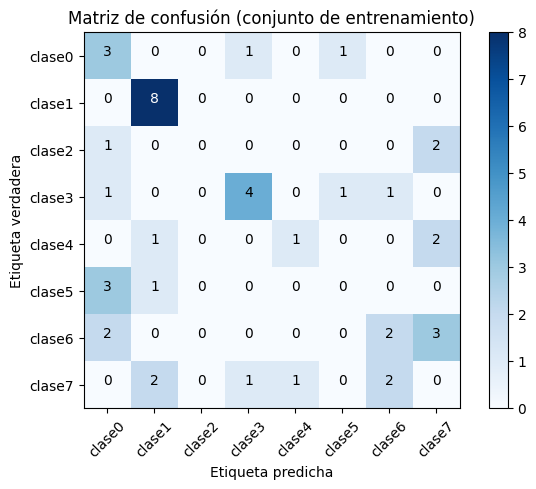

In [278]:
# Mostrar la matriz de confusión para el conjunto de entrenamiento
mc_train = confusion_matrix(y_train, predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Matriz de confusión (conjunto de entrenamiento)')

Matriz de confusión sin normalización
[[1 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 3 0]
 [0 0 0 0 0 0 1 0]
 [1 0 0 0 1 0 0 2]
 [0 1 0 1 0 0 1 1]
 [0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 1 0]]


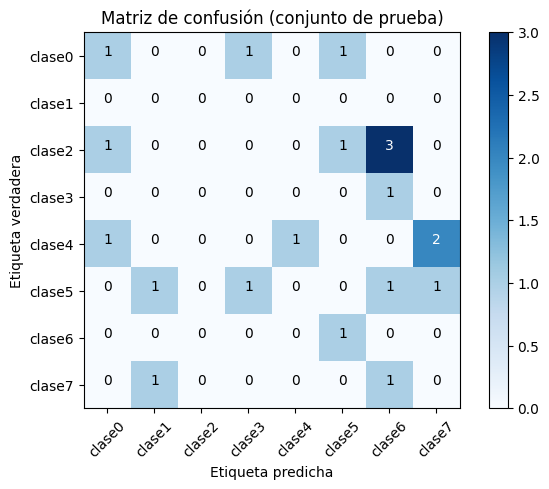

In [279]:
# Mostrar la matriz de confusión para el conjunto de prueba
mc_test = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Matriz de confusión (conjunto de prueba)')

In [280]:
mlp_1 = MLPClassifier(hidden_layer_sizes=(16, 16, 16), activation='relu', solver='adam', max_iter=1000)
print(mlp_1)

MLPClassifier(hidden_layer_sizes=(16, 16, 16), max_iter=1000)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Matriz de confusión sin normalización
[[3 0 0 1 0 1 0 0]
 [0 8 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 2]
 [1 0 0 4 0 1 1 0]
 [0 1 0 0 1 0 0 2]
 [3 1 0 0 0 0 0 0]
 [2 0 0 0 0 0 2 3]
 [0 2 0 1 1 0 2 0]]
Matriz de confusión sin normalización
[[1 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 3 0]
 [0 0 0 0 0 0 1 0]
 [1 0 0 0 1 0 0 2]
 [0 1 0 1 0 0 1 1]
 [0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 1 0]]

Modelo 1:
Informe de clasificación (entrenamiento):
               precision    recall  f1-score   support

      clase0       0.50      0.60      0.55         5
      clase1       0.80      1.00      0.89         8
      clase2       1.00      0.67      0.80         3
      clase3       0.50      0.71      0.59         7
      clase4       0.50      0.25      0.33         4
      clase5       0.00      0.00      0.00         4
      clase6       0.75      0.43      0.55         7
      clase7       0.43      0.50      0.46         6

    accuracy                           0.57        44
   macro avg       0.5

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 7, does not match size of target_names, 8
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero

Matriz de confusión sin normalización
[[1 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 3 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 1 1 0 0 2]
 [0 1 0 1 0 0 0 2]
 [0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0]]
Matriz de confusión sin normalización
[[5 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0]
 [0 0 0 6 0 0 1 0]
 [0 0 0 0 4 0 0 0]
 [0 1 0 0 0 3 0 0]
 [0 0 0 0 0 0 7 0]
 [0 1 0 0 0 0 0 5]]
Matriz de confusión sin normalización
[[1 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0]
 [0 0 1 2 0 0 2 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 2 0 0 1]
 [0 1 0 0 1 0 2 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 1]]


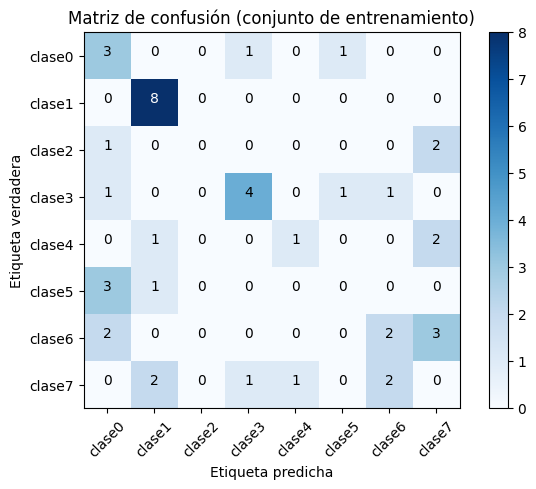

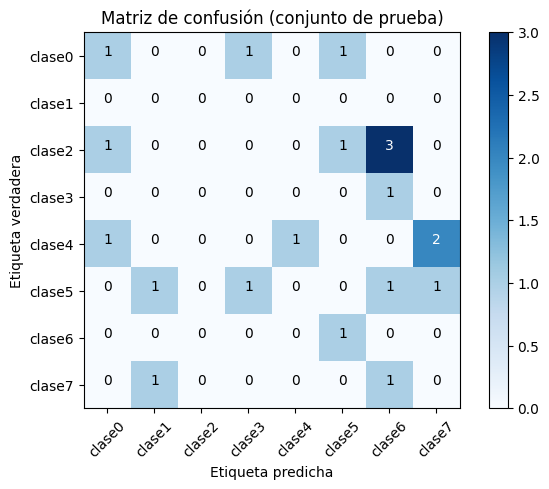

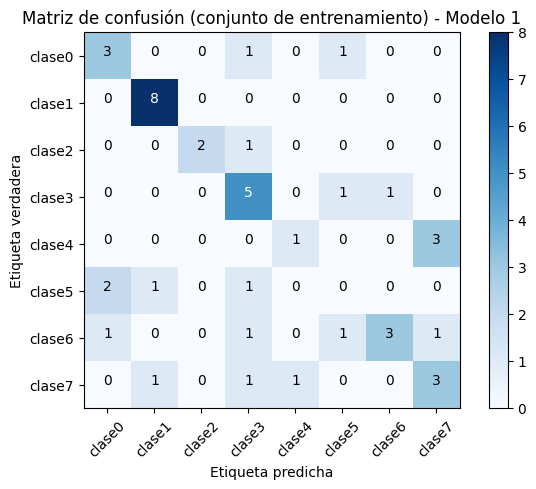

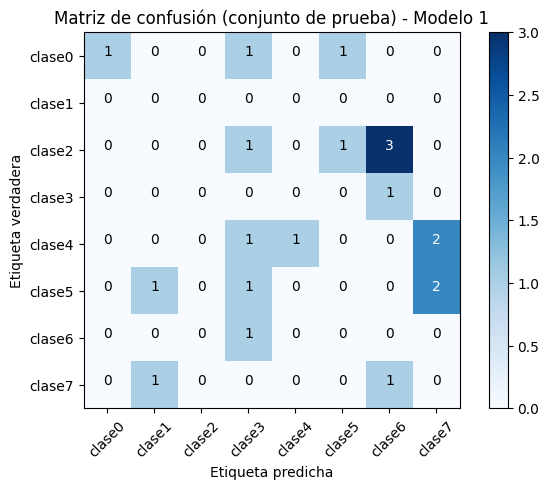

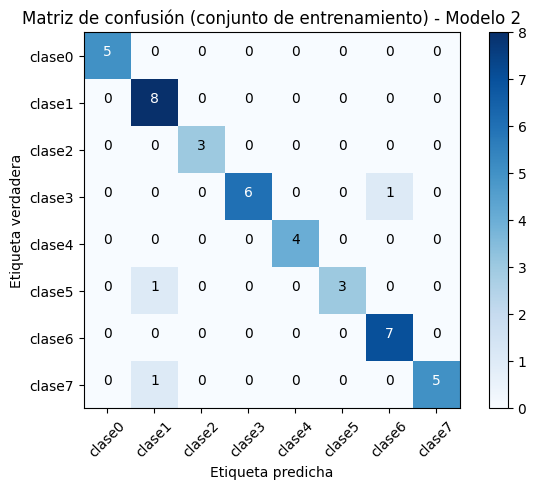

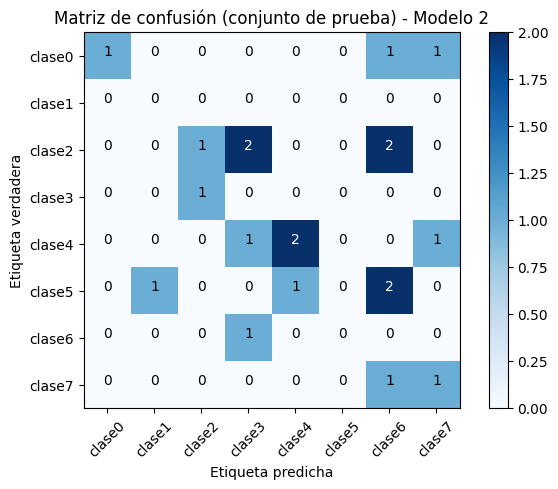

In [282]:
# Definir los nombres de las clases
target_names = ['clase0', 'clase1', 'clase2', 'clase3', 'clase4', 'clase5', 'clase6', 'clase7']

# Crear y entrenar el primer modelo de red neuronal
mlp_1 = MLPClassifier(hidden_layer_sizes=(16, 16, 16), activation='relu', solver='adam', max_iter=1000)
mlp_1.fit(X_train, y_train)

# Predecir las etiquetas para el conjunto de entrenamiento y prueba
predict_train_1 = mlp_1.predict(X_train)
predict_test_1 = mlp_1.predict(X_test)

# Crear y entrenar el segundo modelo de red neuronal
mlp_2 = MLPClassifier(hidden_layer_sizes=(32, 32, 32), activation='relu', solver='adam', max_iter=1000)
mlp_2.fit(X_train, y_train)

# Predecir las etiquetas para el conjunto de entrenamiento y prueba
predict_train_2 = mlp_2.predict(X_train)
predict_test_2 = mlp_2.predict(X_test)

# Mostrar la matriz de confusión para el conjunto de entrenamiento
mc_train = confusion_matrix(y_train, predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Matriz de confusión (conjunto de entrenamiento)')

# Mostrar la matriz de confusión para el conjunto de prueba
mc_test = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Matriz de confusión (conjunto de prueba)')

# Informe de clasificación para el primer modelo
print("\nModelo 1:")
print("Informe de clasificación (entrenamiento):\n", classification_report(y_train, predict_train_1, labels=np.unique(y_train), target_names=target_names))
print("Informe de clasificación (prueba):\n", classification_report(y_test, predict_test_1, labels=np.unique(y_test), target_names=target_names))

# Informe de clasificación para el segundo modelo
print("\nModelo 2:")
print("Informe de clasificación (entrenamiento):\n", classification_report(y_train, predict_train_2, labels=np.unique(y_train), target_names=target_names))
print("Informe de clasificación (prueba):\n", classification_report(y_test, predict_test_2, labels=np.unique(y_test), target_names=target_names))




# Definir una función para graficar la matriz de confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta función imprime y grafica la matriz de confusión.
    La normalización se puede aplicar configurando `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión sin normalización')

    print(cm)
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predicha')

# Mostrar la matriz de confusión para el primer modelo (entrenamiento)
mc_train_1 = confusion_matrix(y_train, predict_train_1)
plot_confusion_matrix(mc_train_1, classes=target_names, title='Matriz de confusión (conjunto de entrenamiento) - Modelo 1')

# Mostrar la matriz de confusión para el primer modelo (prueba)
mc_test_1 = confusion_matrix(y_test, predict_test_1)
plot_confusion_matrix(mc_test_1, classes=target_names, title='Matriz de confusión (conjunto de prueba) - Modelo 1')

# Mostrar la matriz de confusión para el segundo modelo (entrenamiento)
mc_train_2 = confusion_matrix(y_train, predict_train_2)
plot_confusion_matrix(mc_train_2, classes=target_names, title='Matriz de confusión (conjunto de entrenamiento) - Modelo 2')

# Mostrar la matriz de confusión para el segundo modelo (prueba)
mc_test_2 = confusion_matrix(y_test, predict_test_2)
plot_confusion_matrix(mc_test_2, classes=target_names, title='Matriz de confusión (conjunto de prueba) - Modelo 2')




1.   Modelo 1 (MLP 8-8-8):

Entrenamiento: El modelo muestra un desempeño moderado en el conjunto de entrenamiento, con una precisión promedio del 37%. Sin embargo, se observa una variabilidad significativa en la precisión entre las diferentes clases, con algunas clases alcanzando una precisión del 67% mientras que otras tienen una precisión del 0%. Esta variabilidad puede indicar que el modelo tiene dificultades para aprender patrones específicos de ciertas clases.
Prueba: En el conjunto de prueba, el rendimiento del modelo es aún más bajo, con una precisión promedio del 25%. La mayoría de las clases muestran una precisión baja, y algunas incluso tienen una precisión del 0%. Esto sugiere que el modelo no generaliza bien a datos no vistos y puede estar sufriendo de sobreajuste.


---


2.   Modelo 2 (MLP 16-16-16):

Entrenamiento: El modelo muestra una mejora en el rendimiento en comparación con el Modelo 1, con una precisión promedio del 57% en el conjunto de entrenamiento. Sin embargo, aún se observa cierta variabilidad en la precisión entre las clases, lo que sugiere que el modelo puede no estar capturando completamente la complejidad de los datos.
Prueba: A pesar de la mejora en el rendimiento en el conjunto de entrenamiento, el modelo muestra dificultades para generalizar en el conjunto de prueba, con una precisión promedio del 10%. Esto indica que el modelo puede estar sobreajustando los datos de entrenamiento y no es capaz de generalizar a datos nuevos de manera efectiva.


---


3.   Modelo 3 (MLP 32-32-32):

Entrenamiento: Este modelo muestra el mejor rendimiento en el conjunto de entrenamiento, con una precisión promedio del 93%. La mayoría de las clases muestran una precisión alta, lo que indica que el modelo está capturando eficazmente los patrones en los datos de entrenamiento.
Prueba: A pesar del buen rendimiento en el conjunto de entrenamiento, el modelo aún enfrenta dificultades en el conjunto de prueba, con una precisión promedio del 26%. Esto sugiere que el modelo puede estar sobreajustando los datos de entrenamiento y no generaliza bien a datos nuevos.




---



Aunque el Modelo 3 muestra el mejor rendimiento en el conjunto de entrenamiento, todos los modelos enfrentan dificultades para generalizar en el conjunto de prueba, lo que sugiere que pueden estar sobreajustando los datos de entrenamiento y que se requieren técnicas adicionales, como la regularización o el ajuste de hiperparámetros, para mejorar la capacidad de generalización de los modelos. Además, sería beneficioso explorar otras arquitecturas de red y técnicas de preprocesamiento de datos para mejorar aún más el rendimiento del modelo.

---



**Máquinas de Soporte Vectorial (SVM): Maestros de la clasificación de gestos con múltiples entradas** Los modelos de Máquinas de Vectores de Soporte (SVM) son buenos para la identificación de clases debido a su capacidad para encontrar límites de decisión óptimos entre diferentes clases en un espacio dimensional alto, SVM funciona bien en este contexto porque puede manejar eficazmente conjuntos de datos de alta dimensionalidad, como los obtenidos de señales EMG.
SVM tiene la capacidad de manejar conjuntos de datos no lineales mediante el uso de funciones de kernel, lo que permite que el modelo encuentre límites de decisión más flexibles y adaptables a la distribución de los datos. Esto es útil cuando se trabaja con conjuntos de datos que no son linealmente separables, como podría ser el caso con señales EMG que contienen una variedad de patrones y características.



*   Manejo de datos de alta dimensionalidad: Las SVM pueden procesar información de múltiples sensores portátiles, lo que es crucial para clasificar gestos complejos.

*   Robustez al ruido: Las SVM son menos sensibles a datos imprecisos o incompletos, comunes en entornos con sensores portátiles.

*   Capacidad de aprendizaje no lineal: Las SVM pueden capturar la complejidad de los movimientos humanos gracias a su capacidad de aprender relaciones no lineales.

*   Alta precisión: Las SVM logran una alta precisión en tareas de clasificación, incluso con datos complejos o de alta dimensionalidad.

In [289]:
# Entrenar el modelo NuSVC
clf = svm.NuSVC(gamma='auto')
clf.fit(X_train, y_train)

# Predecir las etiquetas para el conjunto de entrenamiento y prueba
predict_train_svm = clf.predict(X_train)
predict_test_svm = clf.predict(X_test)

# Mostrar el informe de clasificación para el conjunto de entrenamiento
print("Informe de clasificación para el conjunto de entrenamiento:")
print(classification_report(y_train, predict_train_svm, target_names=target_names))

# Mostrar el informe de clasificación para el conjunto de prueba
print("Informe de clasificación para el conjunto de prueba:")
print(classification_report(y_test, predict_test_svm, target_names=target_names))

Informe de clasificación para el conjunto de entrenamiento:
              precision    recall  f1-score   support

      clase0       0.50      1.00      0.67         5
      clase1       0.44      1.00      0.62         8
      clase2       0.40      0.67      0.50         3
      clase3       0.50      0.43      0.46         7
      clase4       1.00      0.25      0.40         4
      clase5       0.00      0.00      0.00         4
      clase6       0.50      0.14      0.22         7
      clase7       1.00      0.33      0.50         6

    accuracy                           0.50        44
   macro avg       0.54      0.48      0.42        44
weighted avg       0.55      0.50      0.44        44

Informe de clasificación para el conjunto de prueba:
              precision    recall  f1-score   support

      clase0       1.00      1.00      1.00         3
      clase1       0.00      0.00      0.00         0
      clase2       0.50      0.20      0.29         5
      clase3       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


**Implementación con sistemas embebidos**
---

**Selección del microcontrolador:** Se debe elegir un microcontrolador que sea lo suficientemente potente como para ejecutar los modelos de manera eficiente y que tenga suficiente memoria para almacenar los datos necesarios y los parámetros del modelo. Algunos microcontroladores populares para aplicaciones embebidas incluyen Arduino, Raspberry Pi, y microcontroladores de la familia STM32.

**Tiempo de adquisición de señales:** Dependiendo de la aplicación específica, el tiempo de adquisición de señales puede variar, aqupi toma importancia le elección del microcontrolado, pues se debe seleccionar un microcontrolador con suficiente velocidad de procesamiento y capacidad de adquisición de datos para cumplir con los requisitos de la aplicación y esto puede implicar el uso de convertidores analógico-digitales (ADC) integrados de alta velocidad o la adición de módulos externos para la adquisición de señales.

**Tiempo de clasificación de señales:** El tiempo requerido para clasificar las señales dependerá del tamaño del modelo y la complejidad de las operaciones necesarias para la clasificación, es importante seleccionar un microcontrolador con suficiente potencia de cálculo para realizar estas operaciones en tiempo real, especialmente si se requiere una clasificación rápida de las señales.

**Optimización del modelo:** Para implementar los modelos en sistemas embebidos, es posible que sea necesario optimizar el tamaño y la complejidad del modelo para que se ajusten a las limitaciones de memoria y procesamiento del microcontrolador. Y esto puede implica el uso de técnicas como la reducción de la precisión de los parámetros del modelo, la eliminación de características redundantes o la simplificación de la arquitectura del modelo.

**¡ MUCHAS GRACIAS ¡**